In [2]:
import numpy as np
import pickle
from helpers.plotting import *
from helpers.process_data import *
import torch
from sklearn.metrics import roc_auc_score, roc_curve
#Paths
working_dir = "../SPP_NRAD/"
per = [0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024]

/home/aegis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Test Dataset

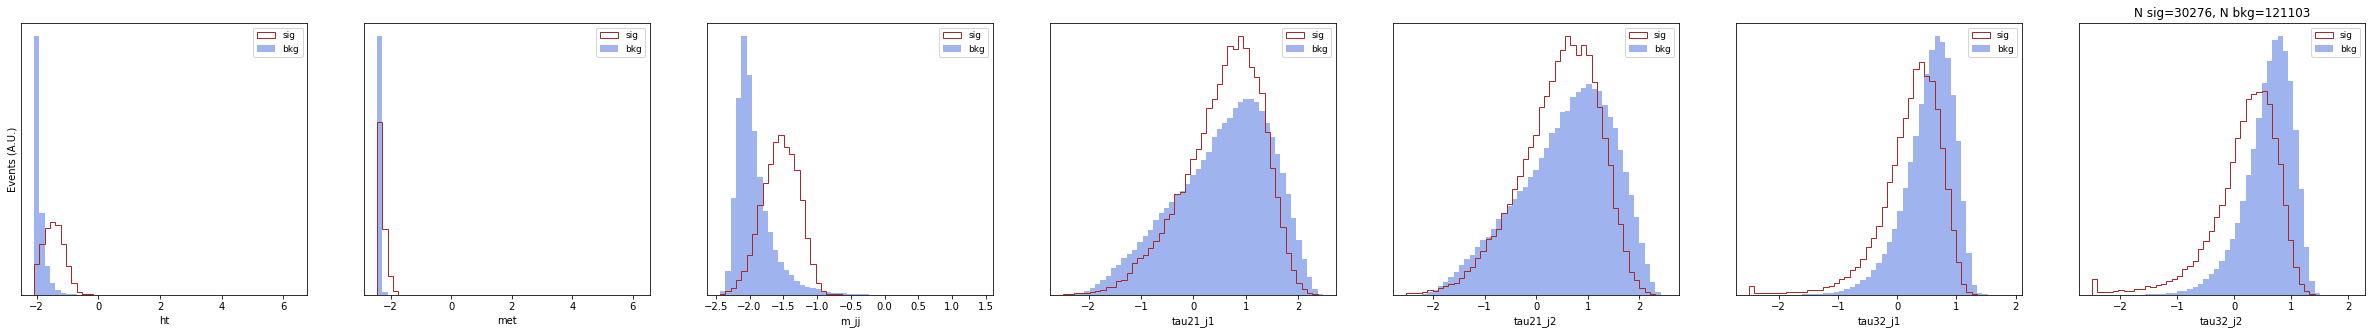

In [3]:
#Path of Test Dataset
test_path = f"{working_dir}/data/test_SR.npz"
#Load Data
test_events = np.load(test_path)
# print(test_events)
sig_list = test_events['sig_events_SR'].T
bkg_list = test_events['bkg_events_SR'].T
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
plot_kwargs = {"labels":["sig", "bkg"], "name":f"sig_vs_bkg_test", "title":f"N sig={len(sig_list[0])}, N bkg={len(bkg_list[0])}"}
plot_all_variables(sig_list, bkg_list, var_names, **plot_kwargs)

### Signal Injection Graphs

In [4]:
gen_seed = 1

with open(f"{working_dir}/data/mc_scaler.pkl","rb") as f:
    print("Loading in trained minmax scaler.")
    scaler = pickle.load(f)
    
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
#Load Data
data = {}
bkg_list = {}
sig_list = {}
data_list = {}
for p in per:
    data[f"{p}"] = np.load(f"{working_dir}/data/seed{gen_seed}/data_{p}.npz")
    sig_list[f"sig_{p}"] = data[f"{p}"]["selected_sigs_sr"].T
    bkg_list[f"bkg_{p}"] = data[f"{p}"]["bkg_events_SR"].T
    data_list[f"data_{p}"] = scaler.inverse_transform(data[f"{p}"]["data_events_sr"]).T

Loading in trained minmax scaler.


/home/aegis/.local/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/home/aegis/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


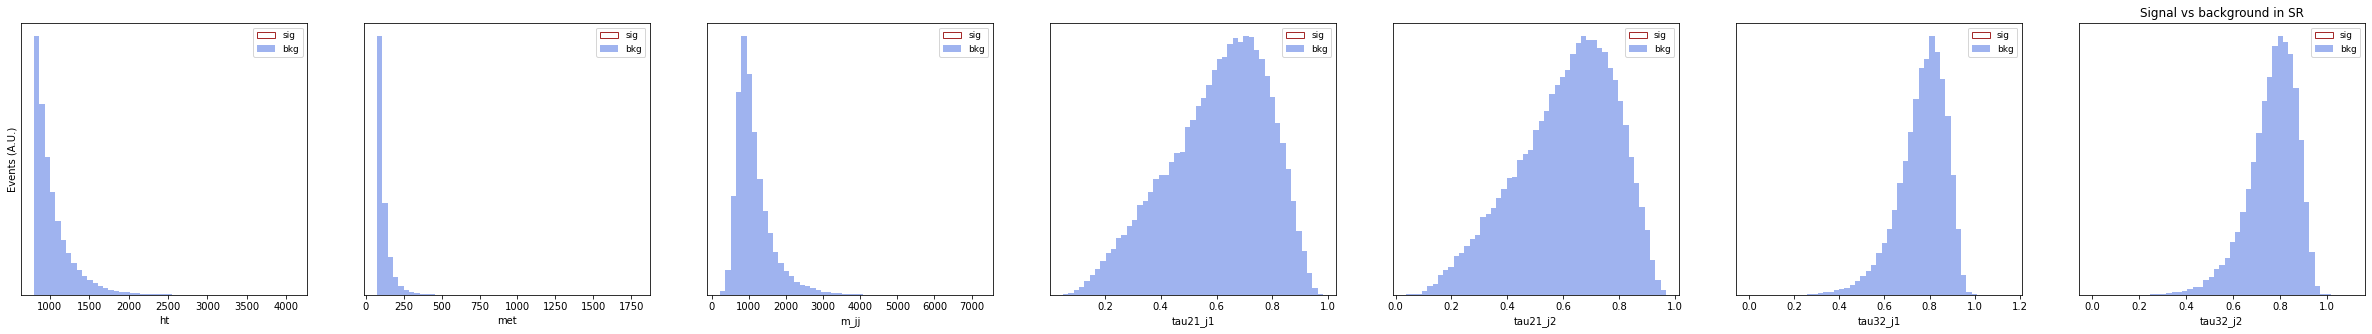

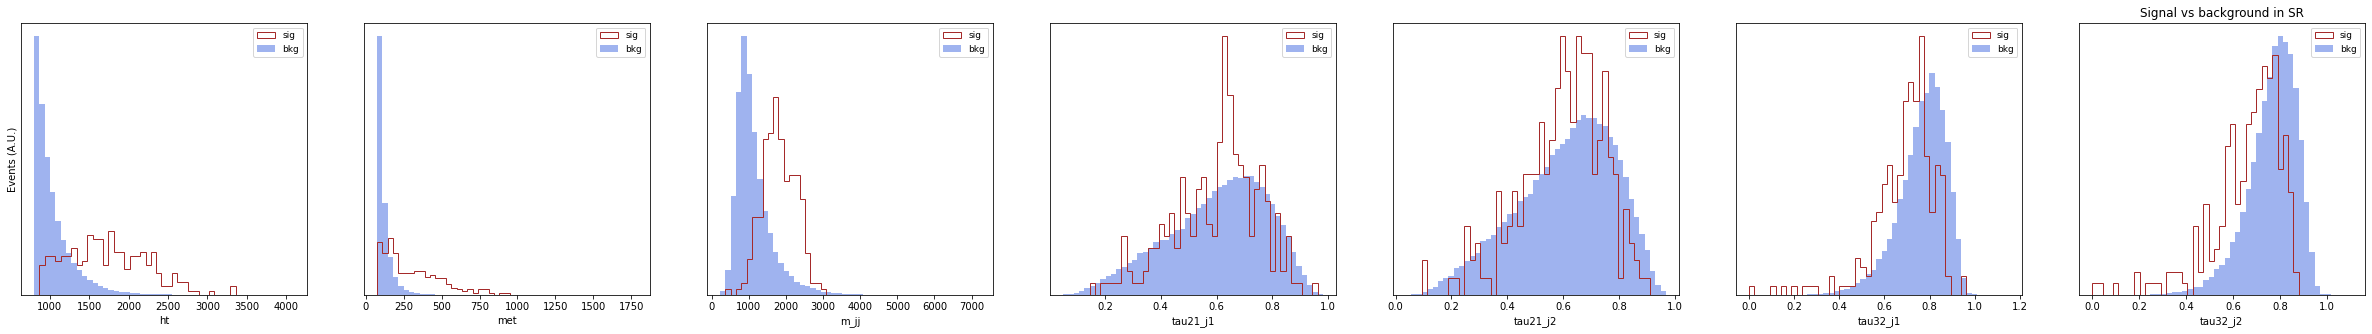

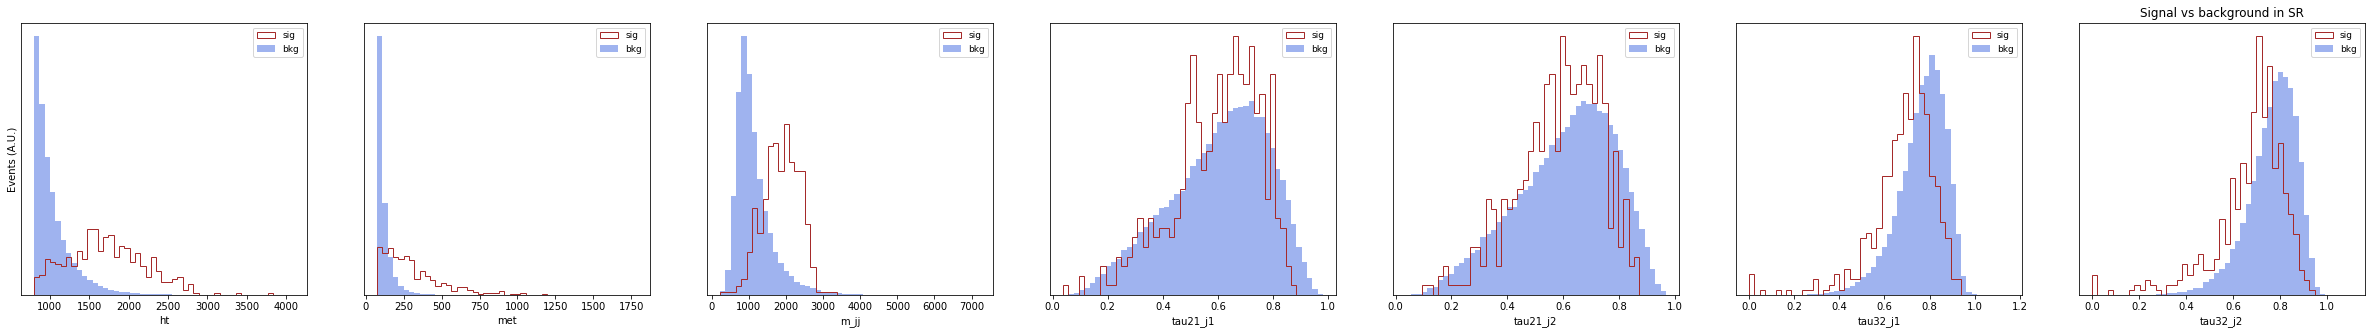

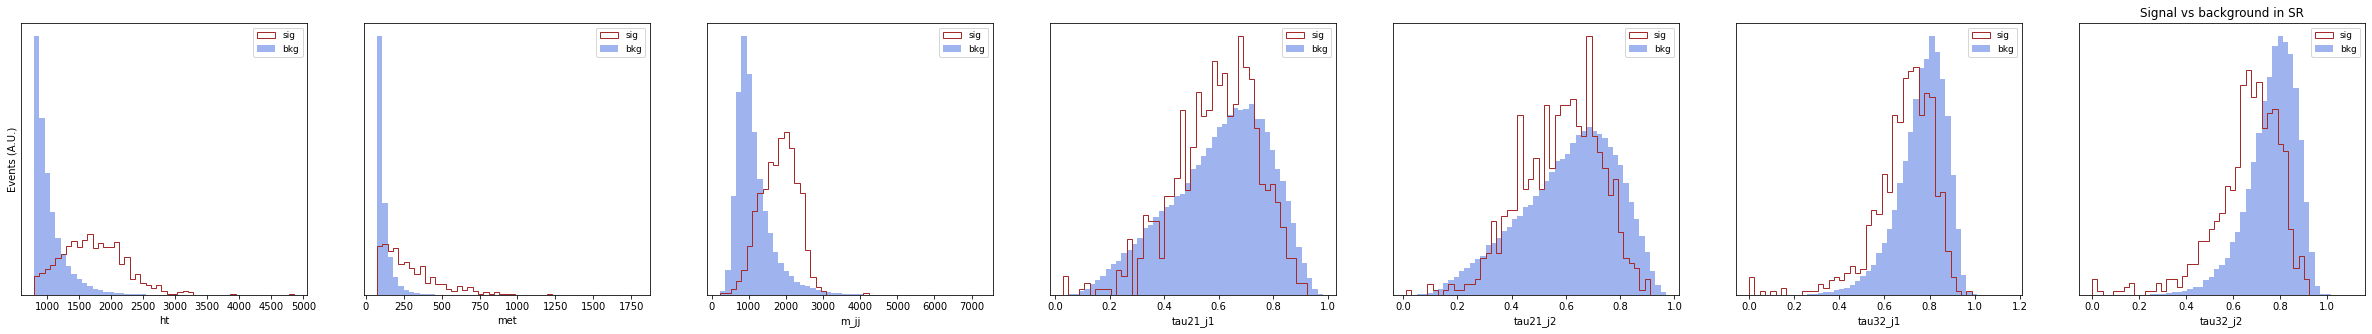

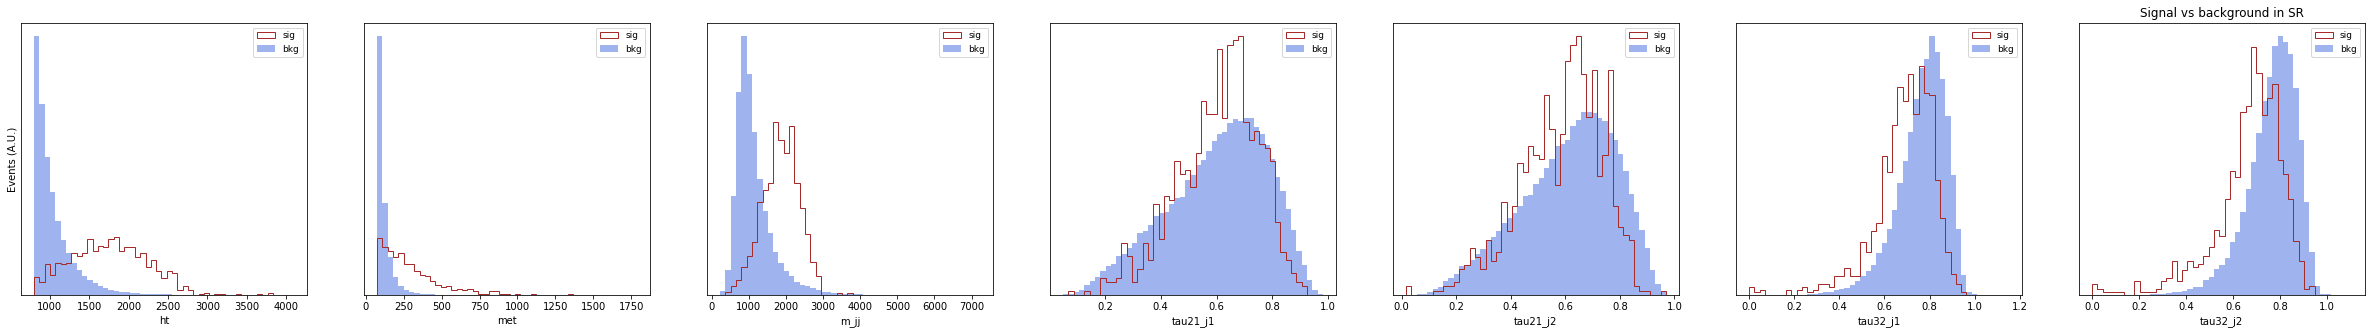

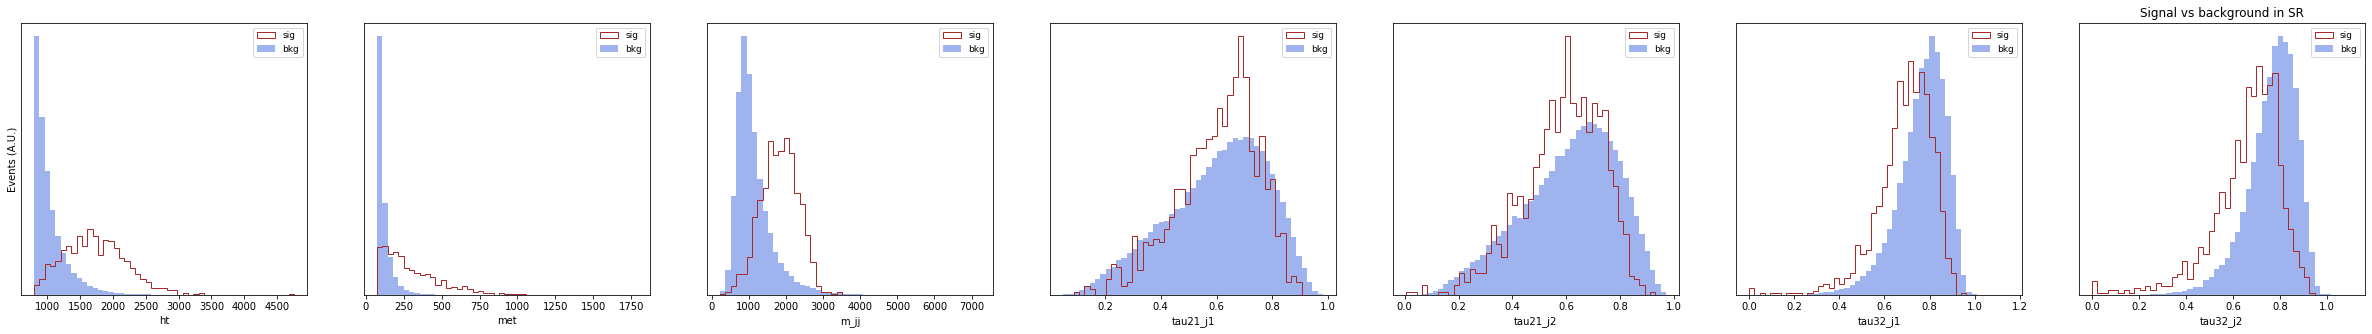

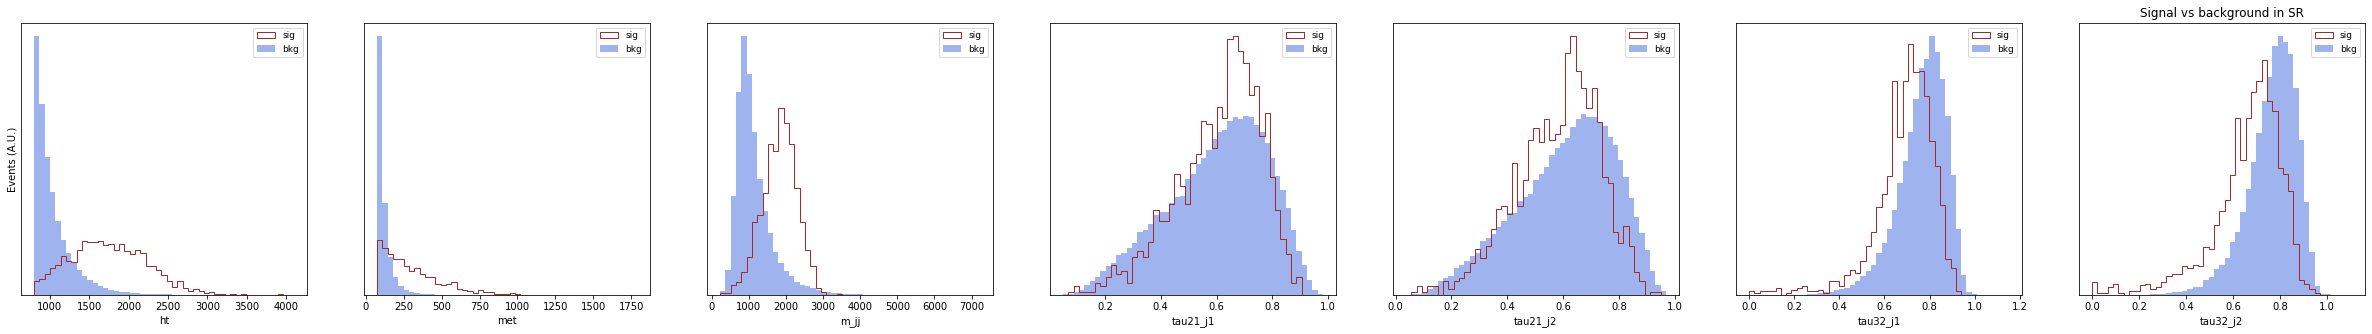

In [4]:
#Signal (SR filtered) vs Background (SR filtered)
for p in per:
    plot_kwargs = {"name":f"sig_vs_bkg_SR_{p}", "title":"Signal vs background in SR"}
    plot_all_variables(sig_list[f"sig_{p}"], bkg_list[f"bkg_{p}"], var_names, **plot_kwargs)

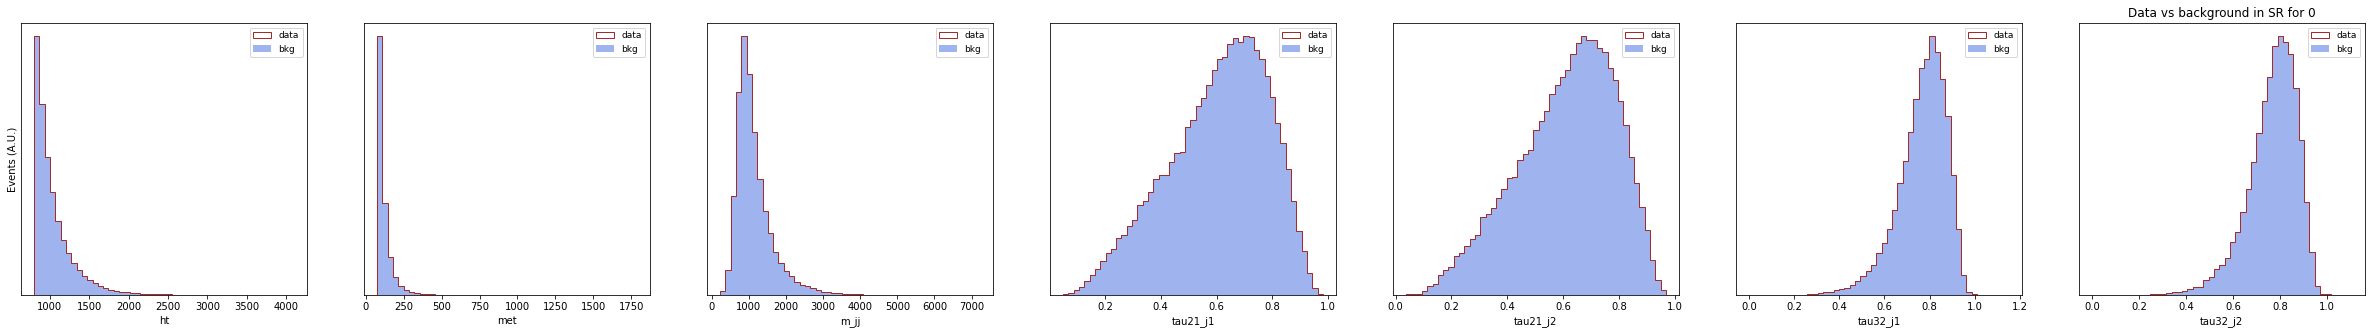

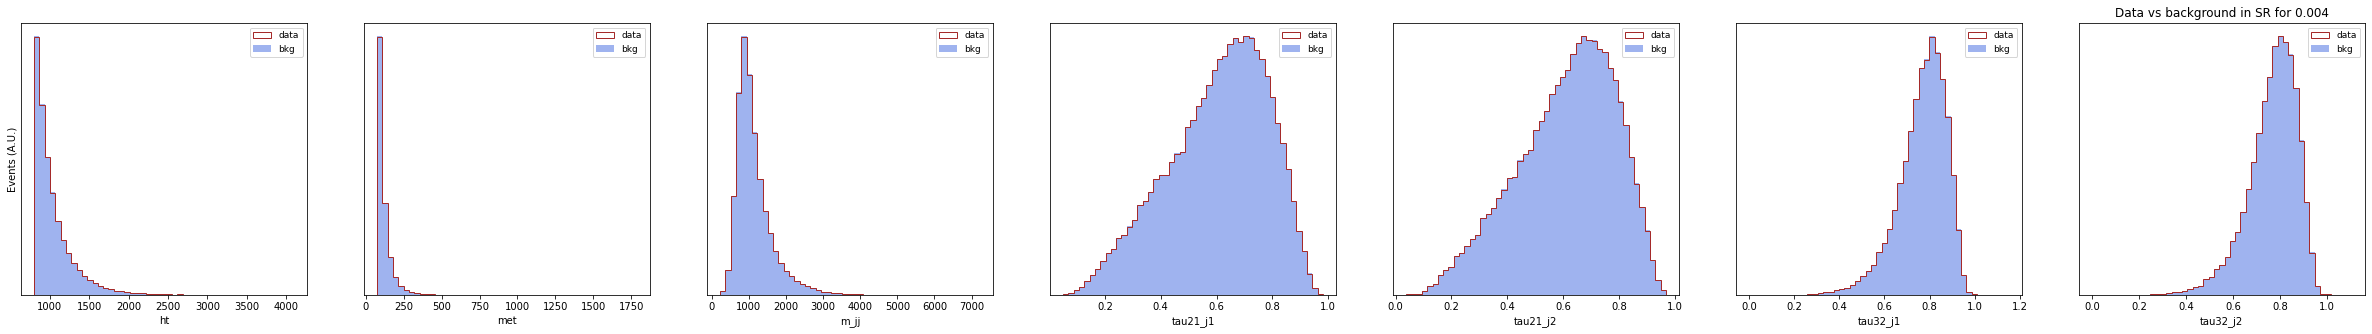

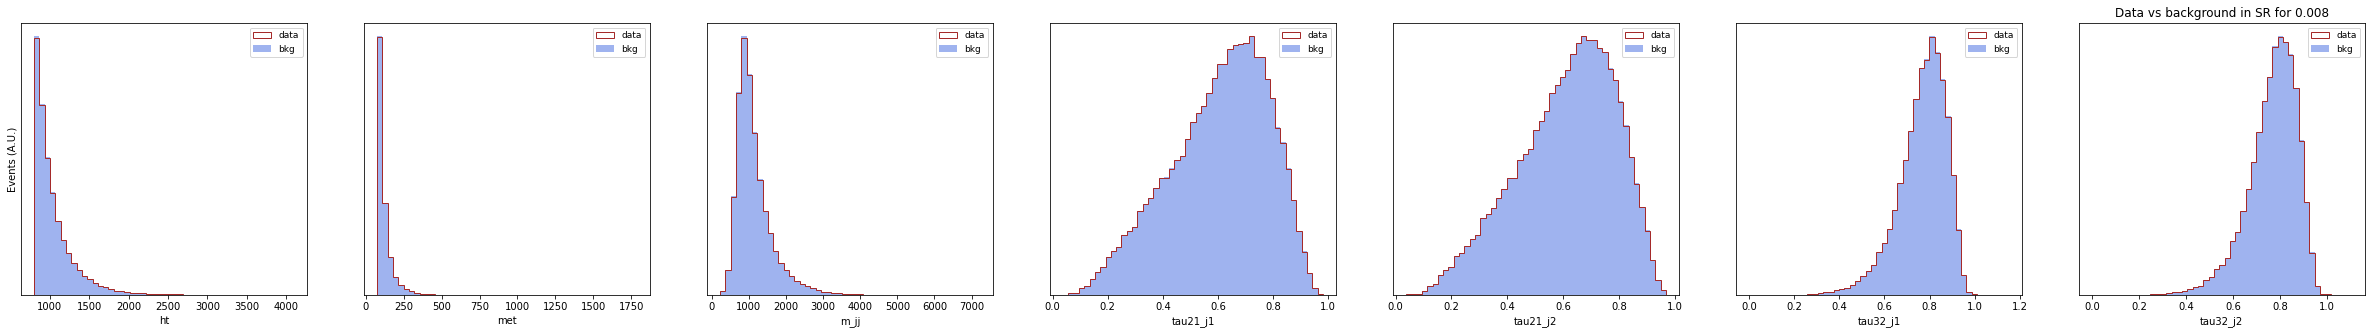

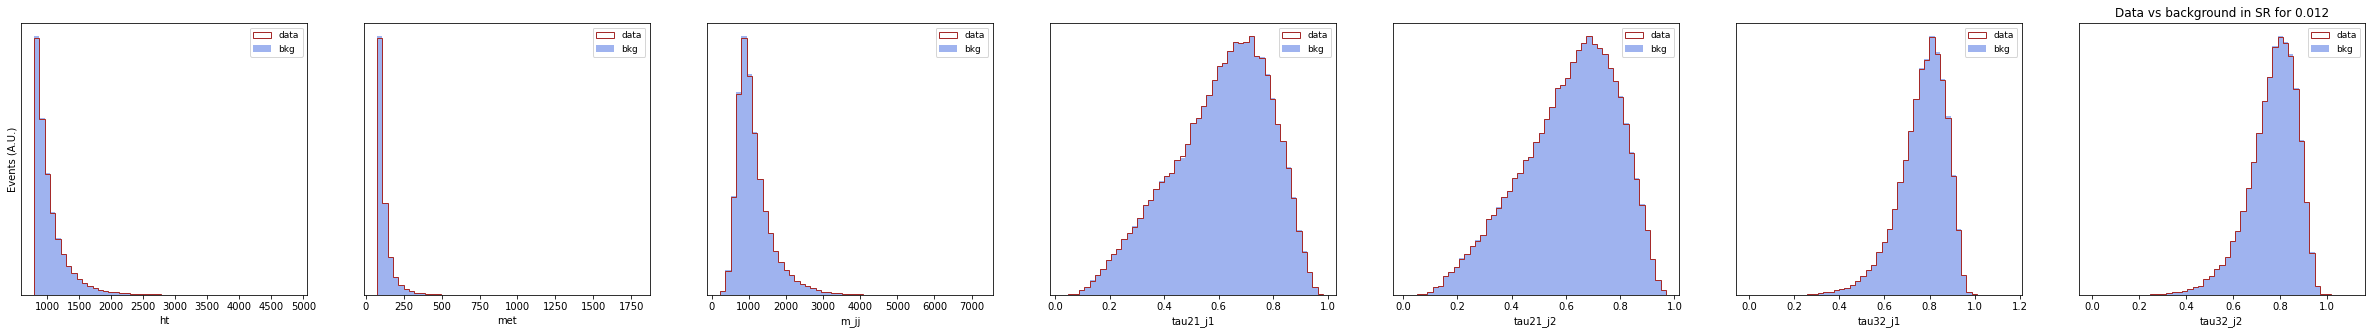

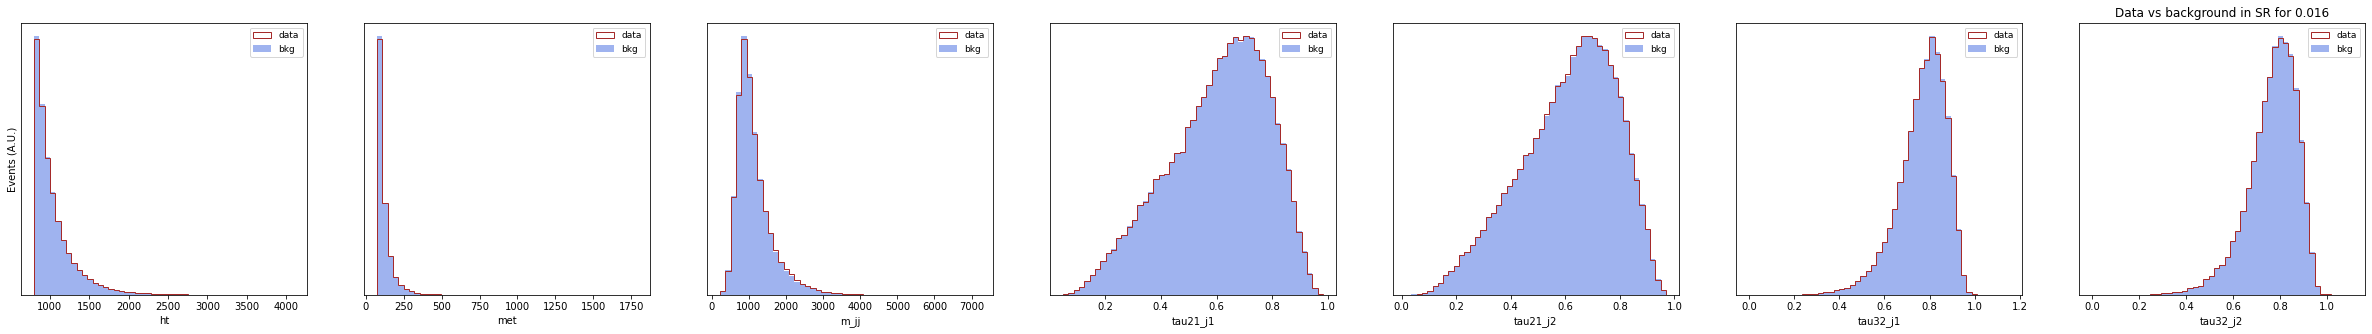

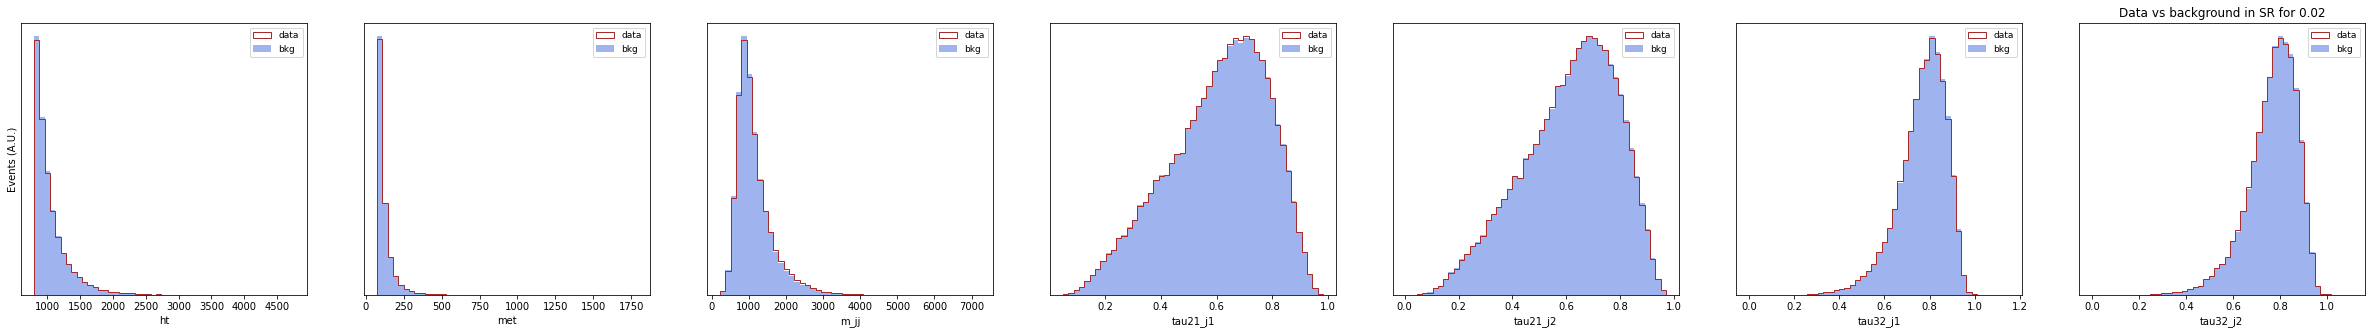

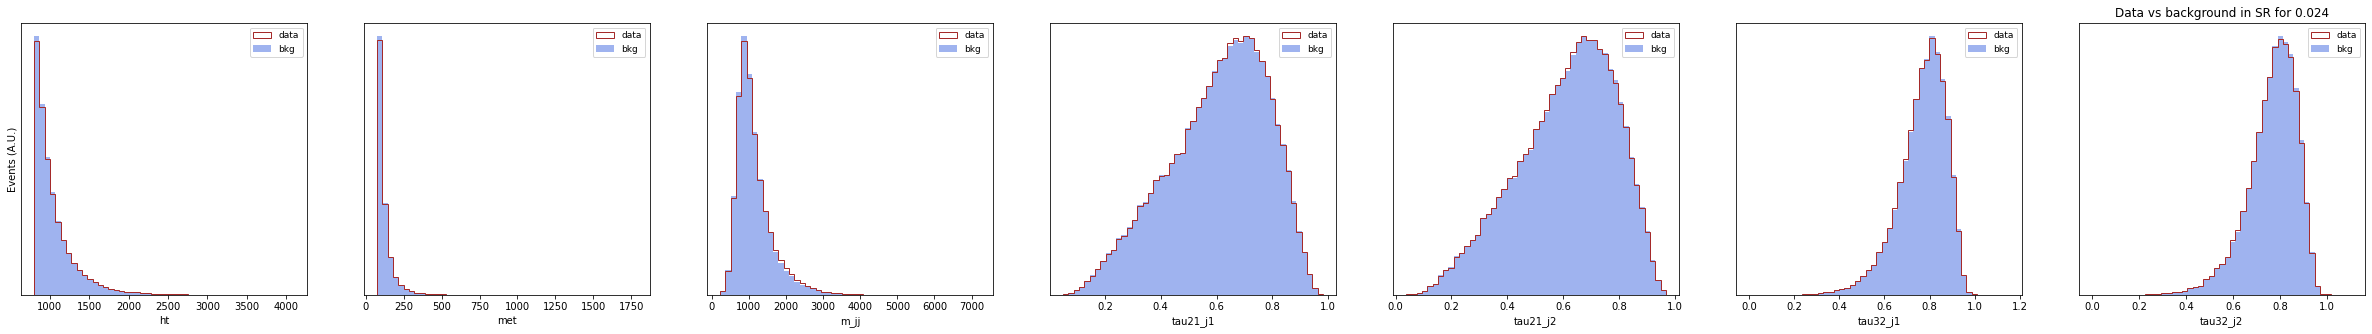

In [5]:
# Data [Bkg + sig] (SR filtered) vs Background (SR filtered)
for p in per:
    plot_kwargs = {"labels":["data", "bkg"], "name":f"data_vs_bkg_SR_{p}", "title":f"Data vs background in SR for {p}"}
    plot_all_variables(data_list[f"data_{p}"], bkg_list[f"bkg_{p}"], var_names, **plot_kwargs)

### Model Training

In [6]:
def plot_loss(epochs, train_loss, val_loss, title):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-', color='blue')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='s', linestyle='--', color='orange')

    plt.title(f"{title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

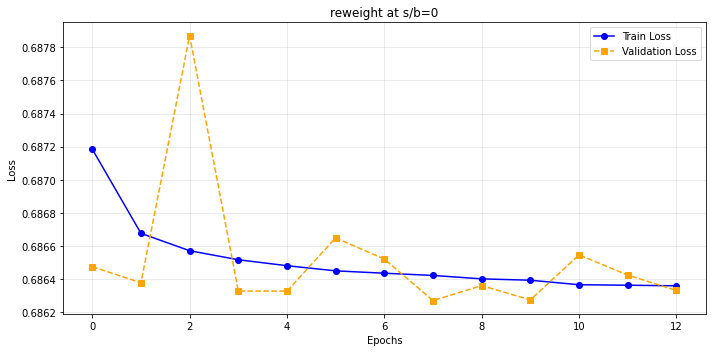

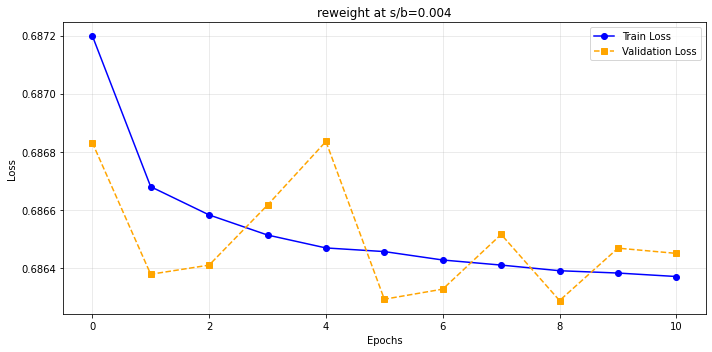

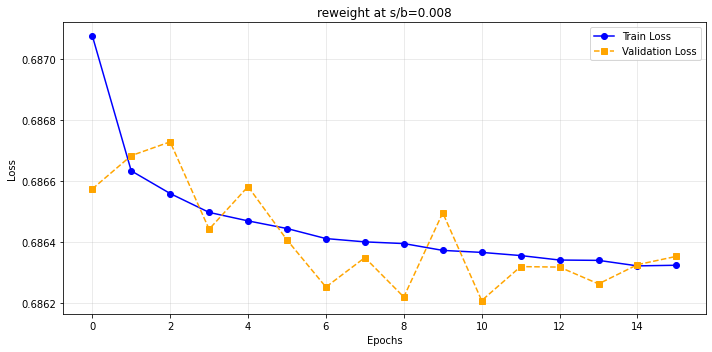

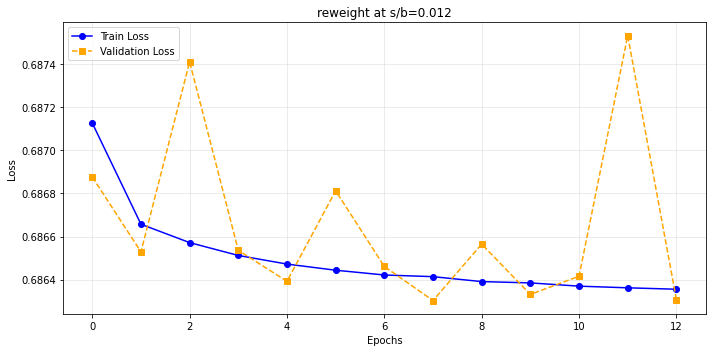

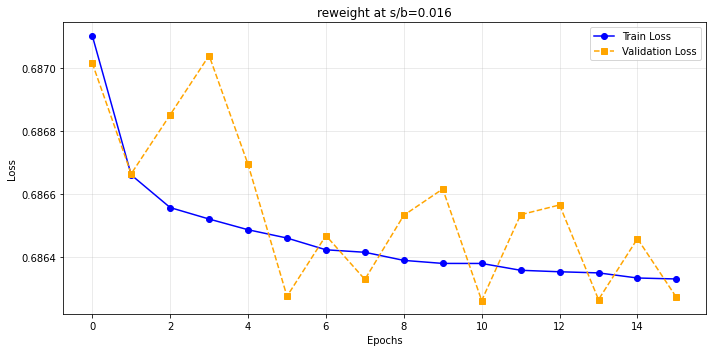

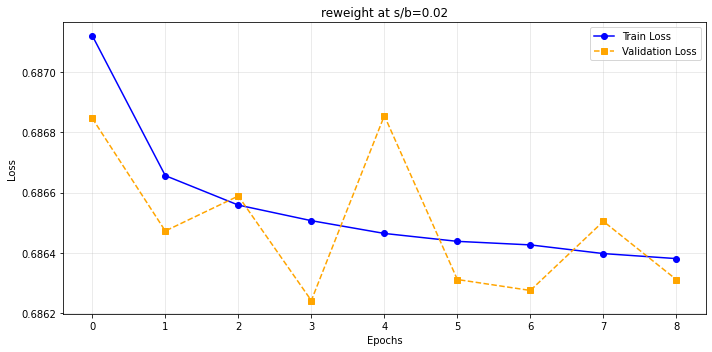

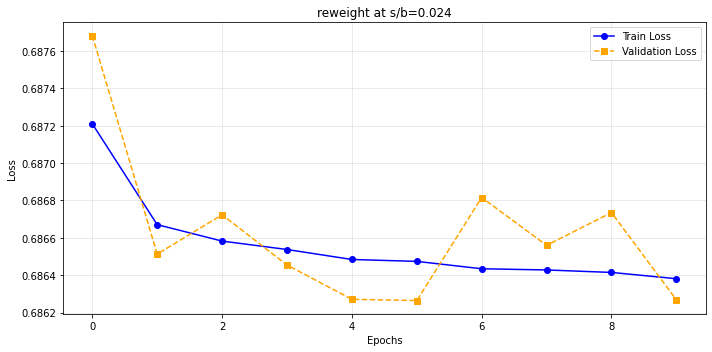

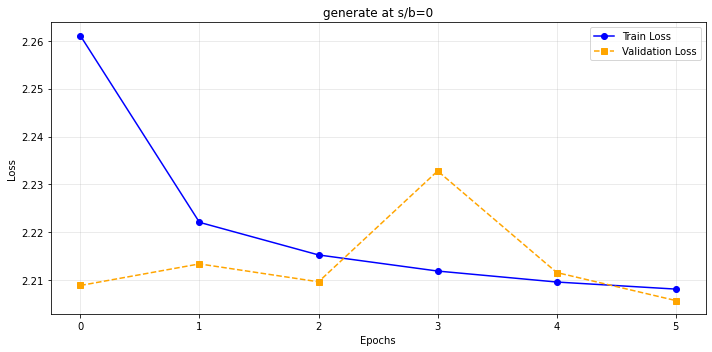

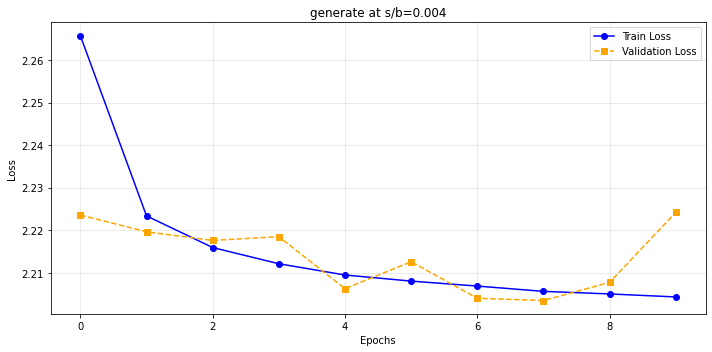

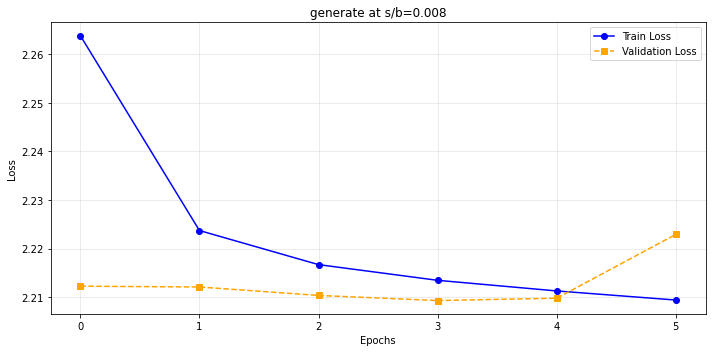

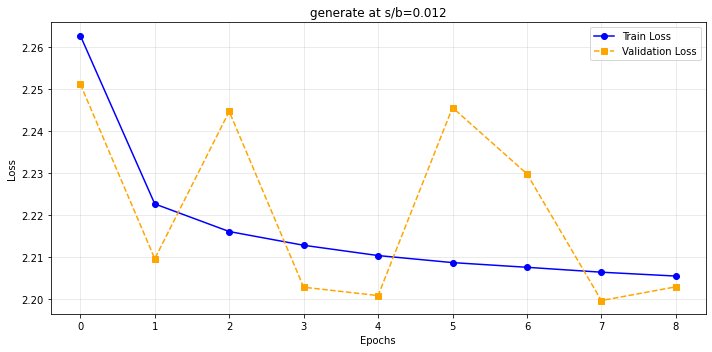

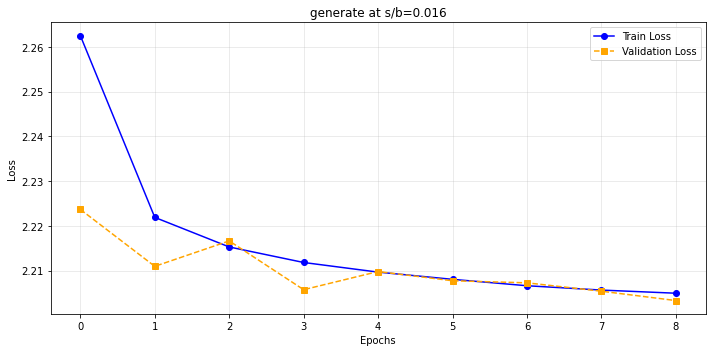

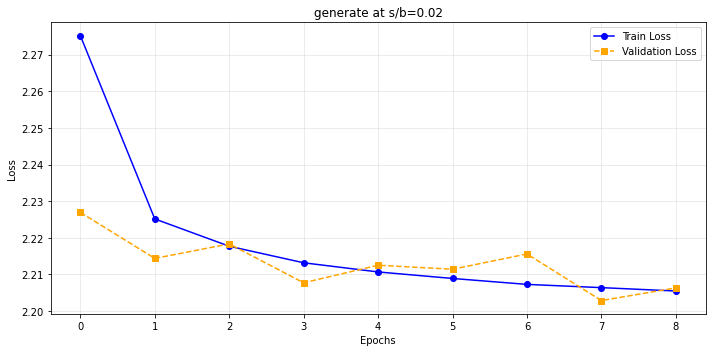

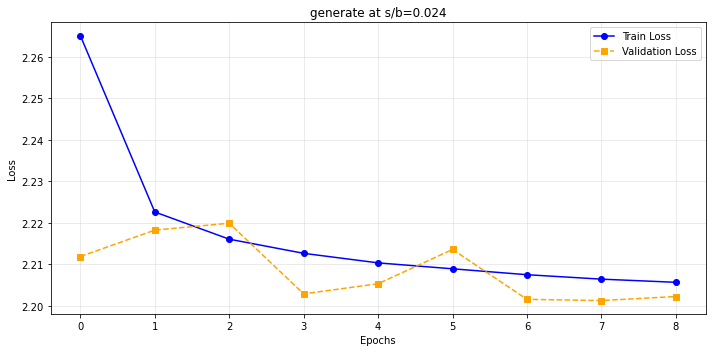

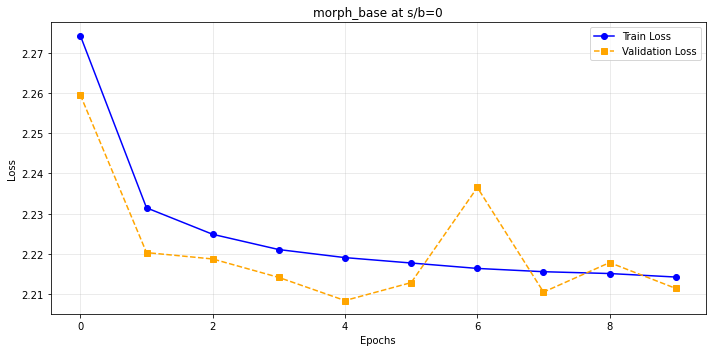

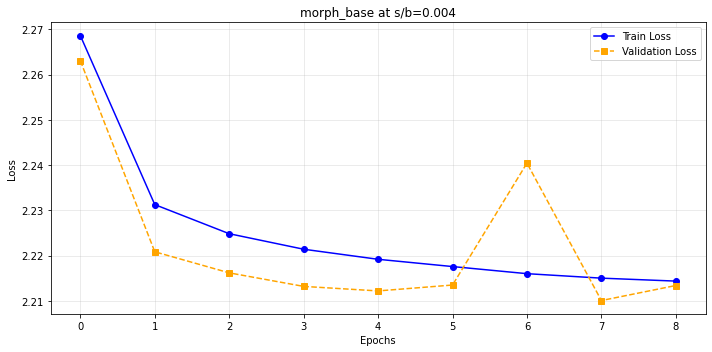

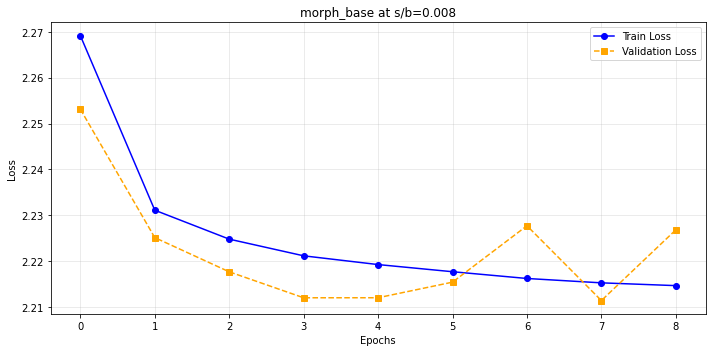

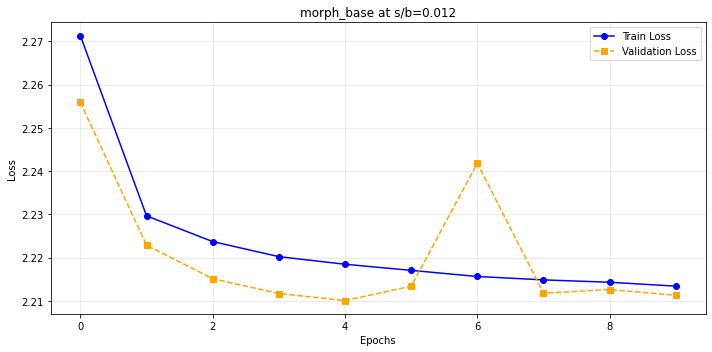

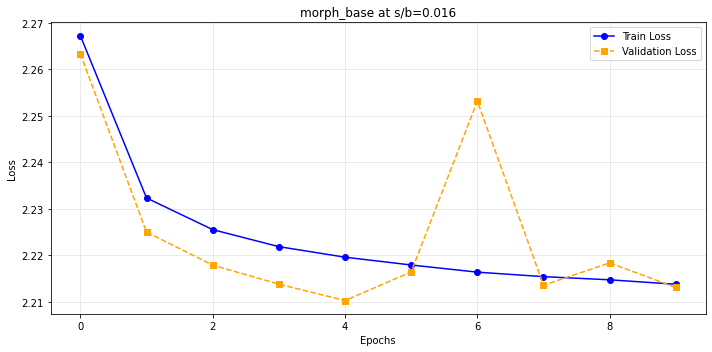

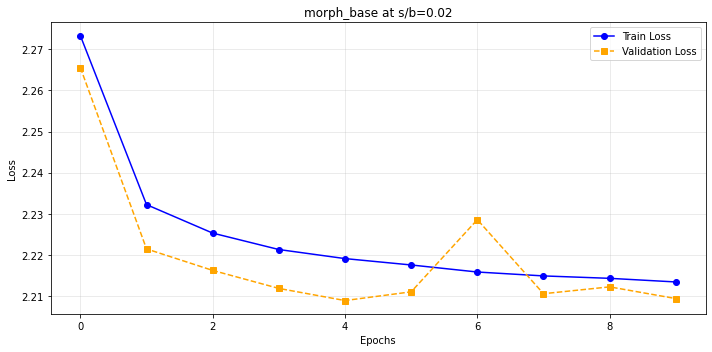

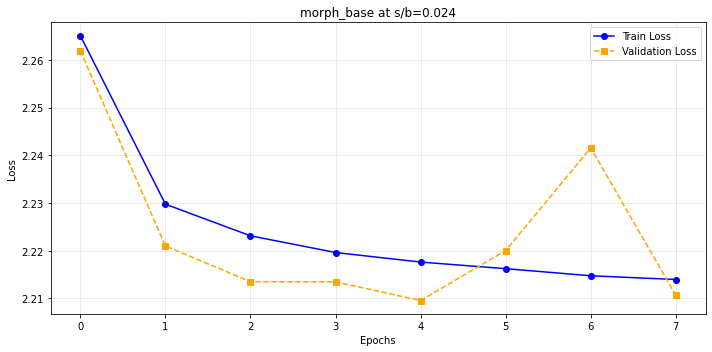

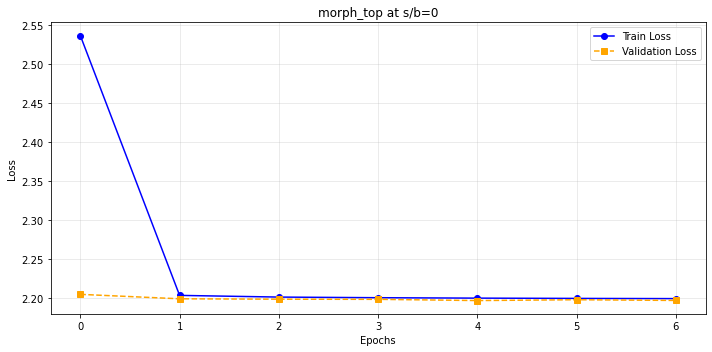

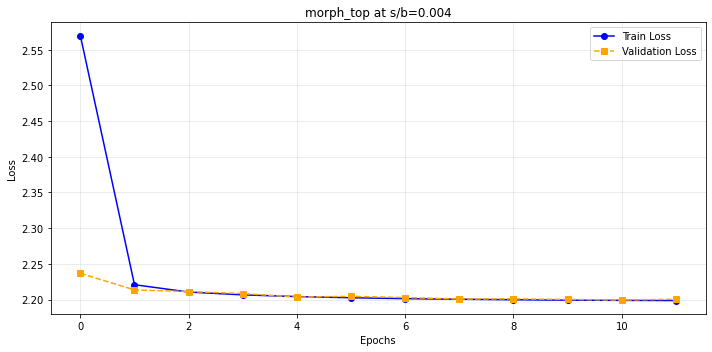

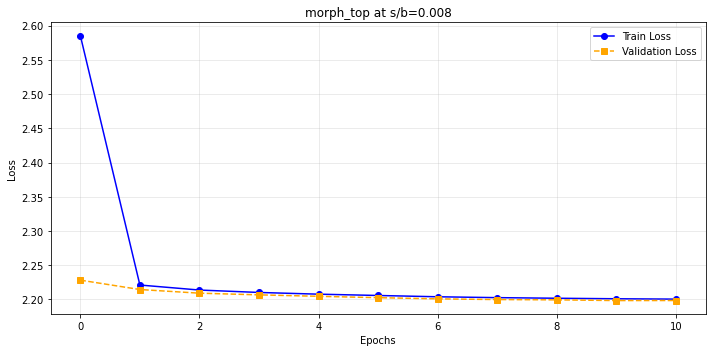

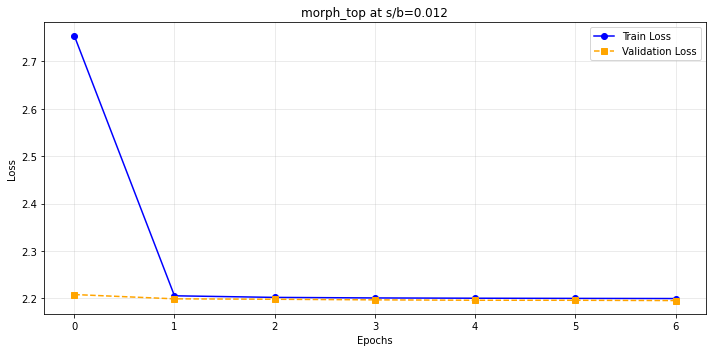

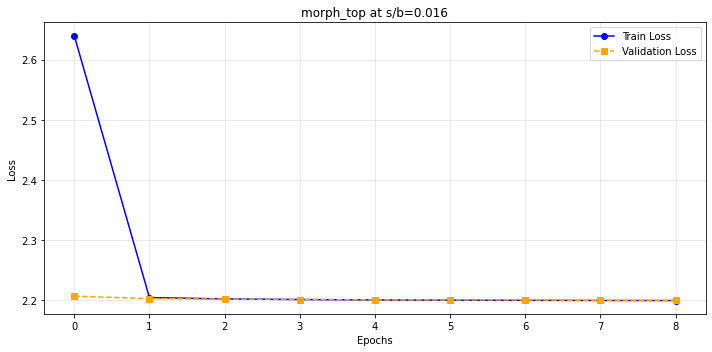

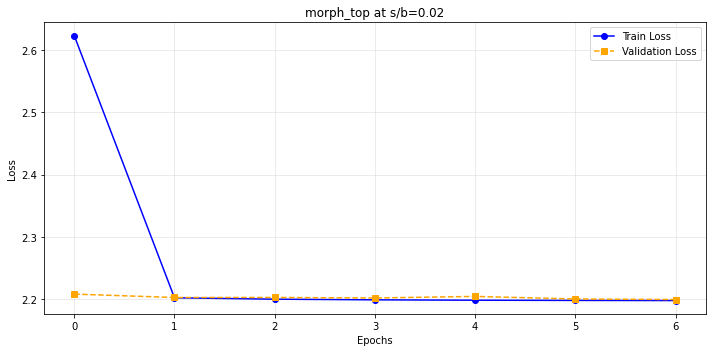

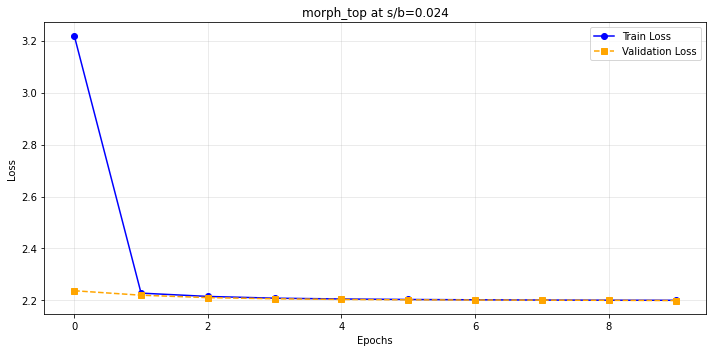

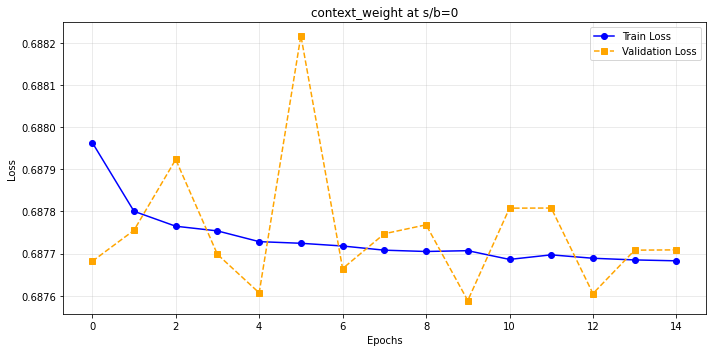

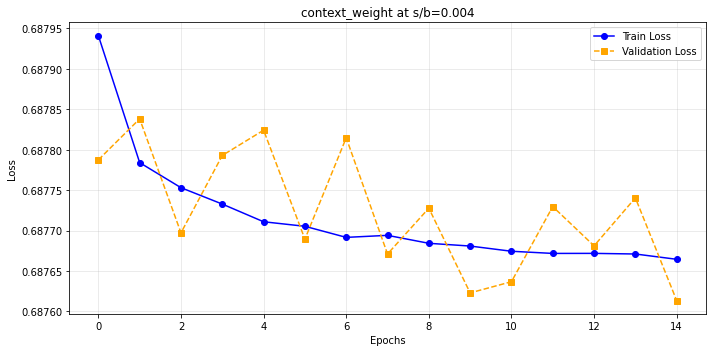

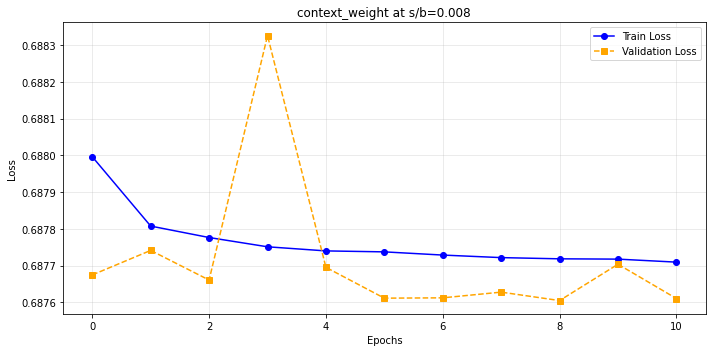

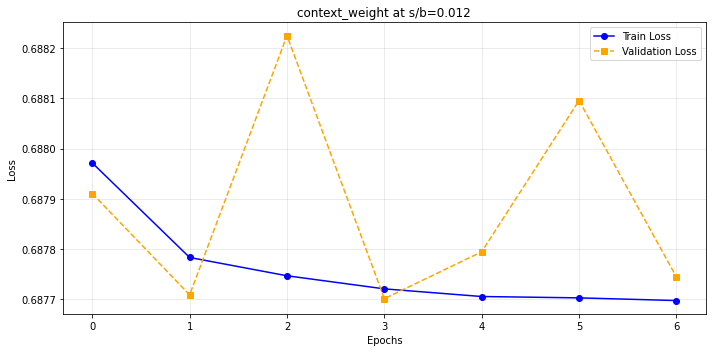

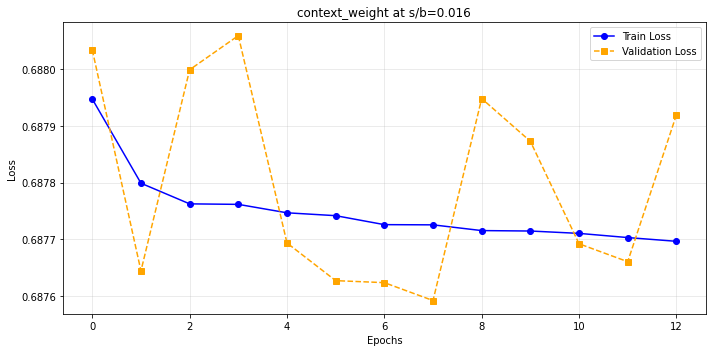

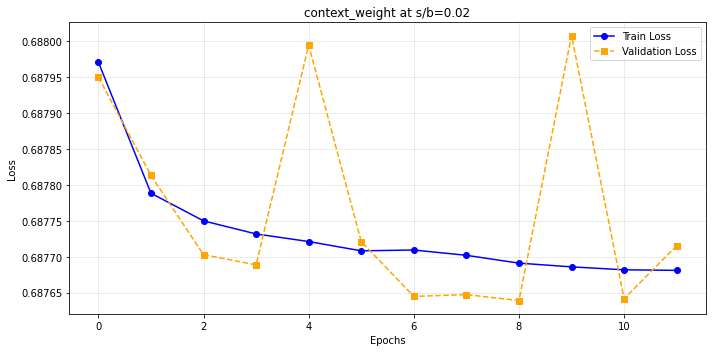

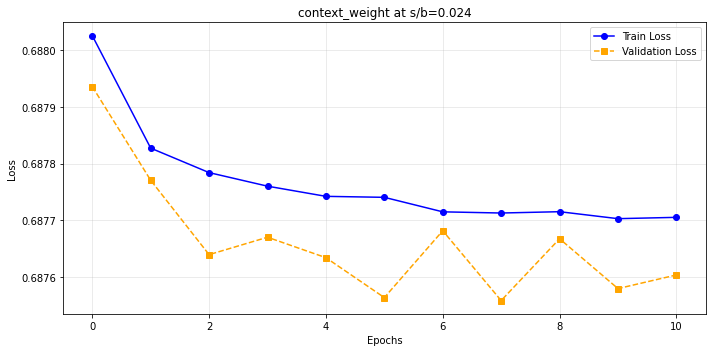

In [7]:
gen_seed = 1
models = ['reweight','generate','morph_base','morph_top','context_weight']

#Paths
loss_path = f"{working_dir}/models/seed{gen_seed}/loss_data"
Loss_Data = {}
for model in models:
    for p in per:
        Loss_Data[f"{model}_{p}"] = np.load(f"{loss_path}/{model}_{p}_loss.npz")
        plot_loss(Loss_Data[f"{model}_{p}"]["epochs"], Loss_Data[f"{model}_{p}"]["train_loss"], Loss_Data[f"{model}_{p}"]["val_loss"], f"{model} at s/b={p}")
        
        

### Sample Generation (Closure Test)

In [8]:
#Sample Path
samples_path = f"{working_dir}/samples/"
# Data Path for Truth
data_path = f"{working_dir}/data/"
gen_seed = 2
n_context = 2
n_samples = 30000
models = ['reweight','generate','morph', 'context_weight']
#Load all Data
CR_Data = {}
SR_Data = {}
Target_Data = {}
for p in per:
    for model in models:
        CR_Data[f"{model}_{p}_cr"] = np.load(f"{samples_path}/seed{gen_seed}/{model}_CR_samples_{p}.npz")
        SR_Data[f"{model}_{p}_sr"] = np.load(f"{samples_path}/seed{gen_seed}/{model}_SR_samples_{p}.npz")
#         print(CR_Data[f"{model}_{p}_cr"])
#         print(SR_Data[f"{model}_{p}_sr"])

samples_cr_dict = {}
samples_sr_dict = {}
weights_cr_dict = {}
weights_sr_dict = {}

In [9]:
for p in per:
    samples_cr_dict[f"truth_{p}"] = np.load(f"{data_path}/seed{gen_seed}/data_{p}.npz")["data_events_cr"][:n_samples,n_context:]
    weights_cr_dict[f"truth_{p}"] = None
    samples_sr_dict[f"truth_{p}"] = np.load(f"{data_path}/seed{gen_seed}/data_{p}.npz")["data_events_sr"][:n_samples,n_context:]
    weights_sr_dict[f"truth_{p}"] = None
    for model in ['reweight', 'generate', 'morph']:
        if model == 'reweight':
            samples_cr_dict[f"{model}_{p}"] = CR_Data[f"{model}_{p}_cr"]["mc_cr"][:,n_context:]
            weights_cr_dict[f"{model}_{p}"] = CR_Data[f"context_weight_{p}_cr"]["w_cr"]
            samples_sr_dict[f"{model}_{p}"] = SR_Data[f"{model}_{p}_sr"]["mc_samples"][:,n_context:]
            weights_sr_dict[f"{model}_{p}"] = SR_Data[f"context_weight_{p}_sr"]["w_sr"]
            if p == 0:
                Target_Data[f"{model}_{p}_cr"] = CR_Data[f"{model}_{p}_cr"]["target_cr"][:,n_context:]
                Target_Data[f"{model}_{p}_sr"] = SR_Data[f"{model}_{p}_sr"]["data_sr"][:,n_context:]
        elif model == 'generate':
            samples_cr_dict[f"{model}_{p}"] = CR_Data[f"{model}_{p}_cr"][f"{model}_cr"]
            weights_cr_dict[f"{model}_{p}"] = None
            samples_sr_dict[f"{model}_{p}"] = SR_Data[f"{model}_{p}_sr"]["samples"]
            weights_sr_dict[f"{model}_{p}"] = None
            if p == 0:
                Target_Data[f"{model}_{p}_cr"] = CR_Data[f"{model}_{p}_cr"]["target_cr"]
                Target_Data[f"{model}_{p}_sr"] = SR_Data[f"{model}_{p}_sr"]["data_sr"]
        elif model == 'morph':
            samples_cr_dict[f"{model}_{p}"] = CR_Data[f"{model}_{p}_cr"][f"{model}_cr"]
            weights_cr_dict[f"{model}_{p}"] = CR_Data[f"context_weight_{p}_cr"]["w_cr"]
            samples_sr_dict[f"{model}_{p}"] = SR_Data[f"{model}_{p}_sr"]["samples"]
            weights_sr_dict[f"{model}_{p}"] = SR_Data[f"context_weight_{p}_sr"]["w_sr"]
            if p == 0:
                Target_Data[f"{model}_{p}_cr"] = CR_Data[f"{model}_{p}_cr"]["target_cr"]
                Target_Data[f"{model}_{p}_sr"] = SR_Data[f"{model}_{p}_sr"]["data_sr"]

In [10]:
#Graph Part
#Labels and stuff
def name_map():
    return {
        "m_jj": "$m_{{\\rm jj}}$",
        "met": "MET",
        "ht": "HT",
        "pT_j1": "Leading jet $p_{{\\rm T}}$",
        "pT_j2": "Sub-leading jet $p_{{\\rm T}}$",
        "tau21_j1": "Leading jet $\\tau_2/\\tau_1$",
        "tau21_j2": "Sub-leading jet $\\tau_2/\\tau_1$",
        "tau32_j1": "Leading jet $\\tau_3/\\tau_2$",
        "tau32_j2": "Sub-leading jet $\\tau_3/\\tau_2$",
        "min_dPhi": "min$\\Delta\\phi(\\rm j_i, \\rm MET)$",
    }

var_names = ["m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
names = name_map()

xlabel_list = [] 
for x in var_names:
    xlabel_list.append(f"{names[x]}")

colors_dict = {}
#Gen_color_dicts
for p in per:
    colors_dict[f"reweight_{p}"] = "forestgreen"
    colors_dict[f"morph_{p}"] = "mediumvioletred"
    colors_dict[f"generate_{p}"] = "darkgoldenrod"
    colors_dict[f"truth_{p}"] = "lightblue"
bins = np.linspace(-3, 3, 30)
bin_centers = 0.5*(bins[1:] + bins[:-1] )

f1 = 24
f2 = 20

n_features = 5

In [11]:
def plot_samples(samples, weights, bins, colors_dict, keys_to_plot, xlabel_list, bin_centers, n_features, f1, f2, p):
    # Ignore warnings for division or invalid operations
    np.seterr(divide='ignore', invalid='ignore')

    # Create a grid of subplots
    fig, ax = plt.subplots(2, n_features, figsize=(5 * n_features, 1.5 * n_features), height_ratios=[2, 1])

    for i in range(n_features):
        # Plot "truth" histogram
        truth_density, _, _ = ax[0, i].hist(
            samples[f"truth_{p}"][:, i],
            color=colors_dict[f"truth_{p}"],
            bins=bins,
            label="Truth (bkg)",
            density=True
        )
        hist_denom, _ = np.histogram(samples[f"truth_{p}"][:, i], bins=bins, density=False)
        errors_denom = np.sqrt(hist_denom)
        ax[0, i].set_xlim(-3, 3)

        # Plot histograms for other datasets and compute ratios
        for k in keys_to_plot:
            loc_density, _, _ = ax[0, i].hist(
                samples[k][:, i],
                bins=bins,
                label=k,
                histtype="step",
                density=True,
                color=colors_dict[k],
                lw=2,
                weights=weights[k]
            )
            loc_hist, _ = np.histogram(samples[k][:, i], bins=bins, density=False, weights=weights[k])

            loc_errors = np.sqrt(loc_hist)
            loc_ratio = loc_density / truth_density
            loc_errors_ratio = np.sqrt(
                (errors_denom / hist_denom) ** 2 + (loc_errors / loc_hist) ** 2
            ) * loc_ratio
            ax[1, i].errorbar(
                bin_centers, loc_ratio, yerr=loc_errors_ratio, linestyle="", color=colors_dict[k], capsize=2
            )

        # Configure x-axis labels and ratio line
        ax[1, i].set_xlabel(xlabel_list[i], fontsize=f1)
        ax[1, i].axhline(1, color="black", linestyle="dashed")
        ax[1, i].set_xlim(-2.5, 2.5)
        ax[1, i].set_xticks(np.arange(-2, 3, 1))
        ax[1, i].set_ylim(0, 2)

    # Configure y-axis labels
    ax[0, 0].set_ylabel("a.u.", fontsize=f1, labelpad=50)
    ax[0, 0].set_yticks([])
    ax[1, 0].set_ylabel("Ratio to \ntruth", fontsize=f1)

    # Remove y-ticks for other plots
    for i in range(1, n_features):
        ax[0, i].set_yticks([])
        ax[1, i].set_yticks([])

    # Add legend
    ax[0, 0].legend(frameon=False, fontsize=f2)

    # Adjust layout
    plt.subplots_adjust(wspace=0, hspace=0)

    # Show the plot in the notebook
    plt.show()


CR Closure


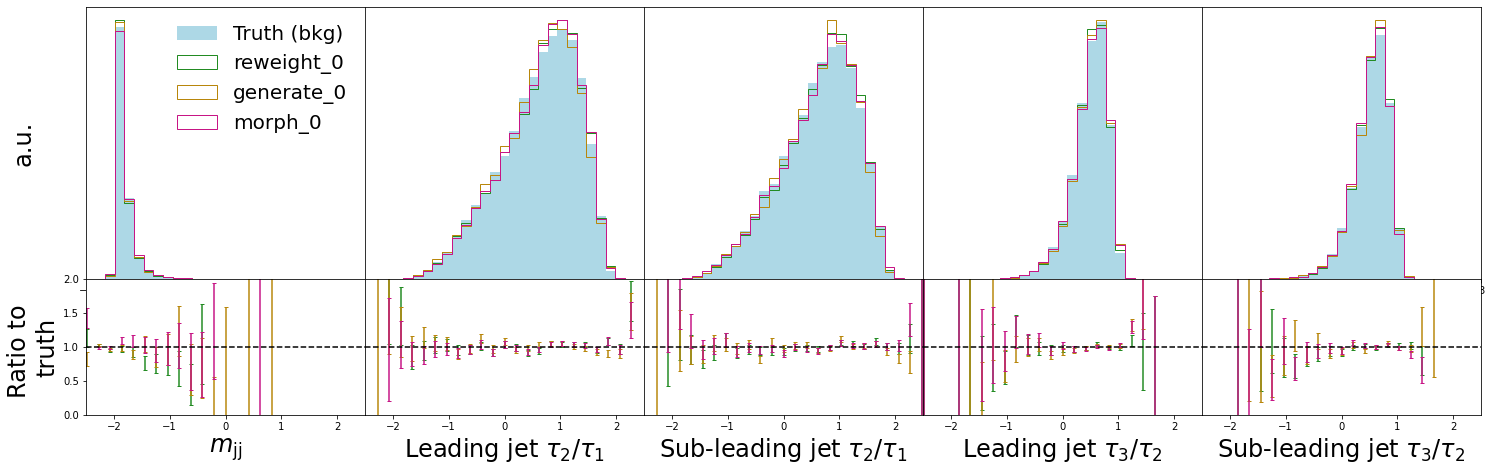

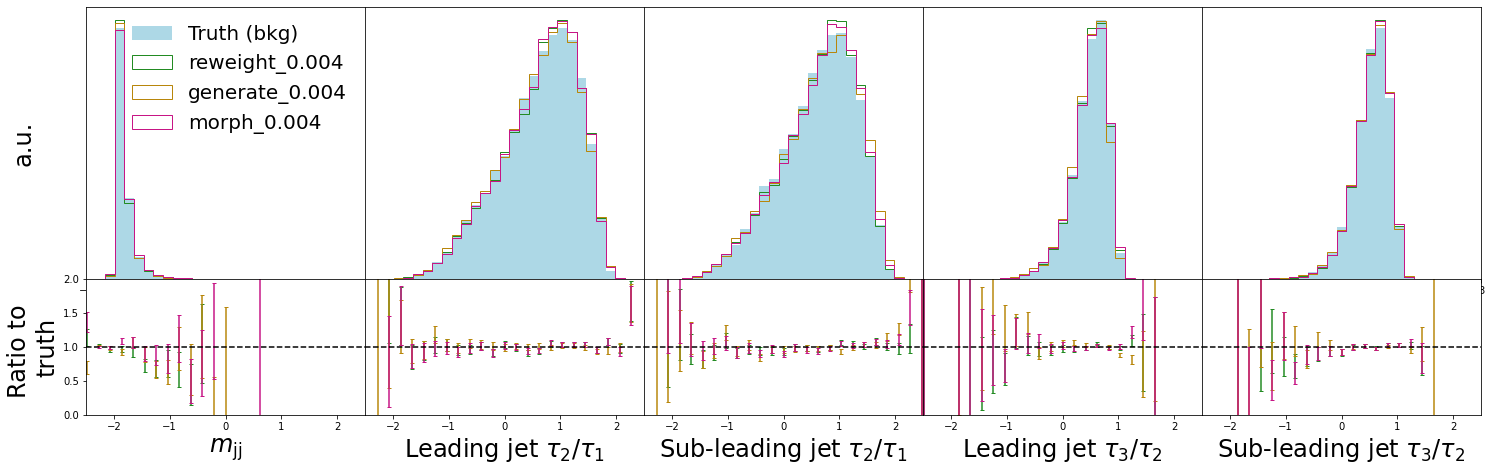

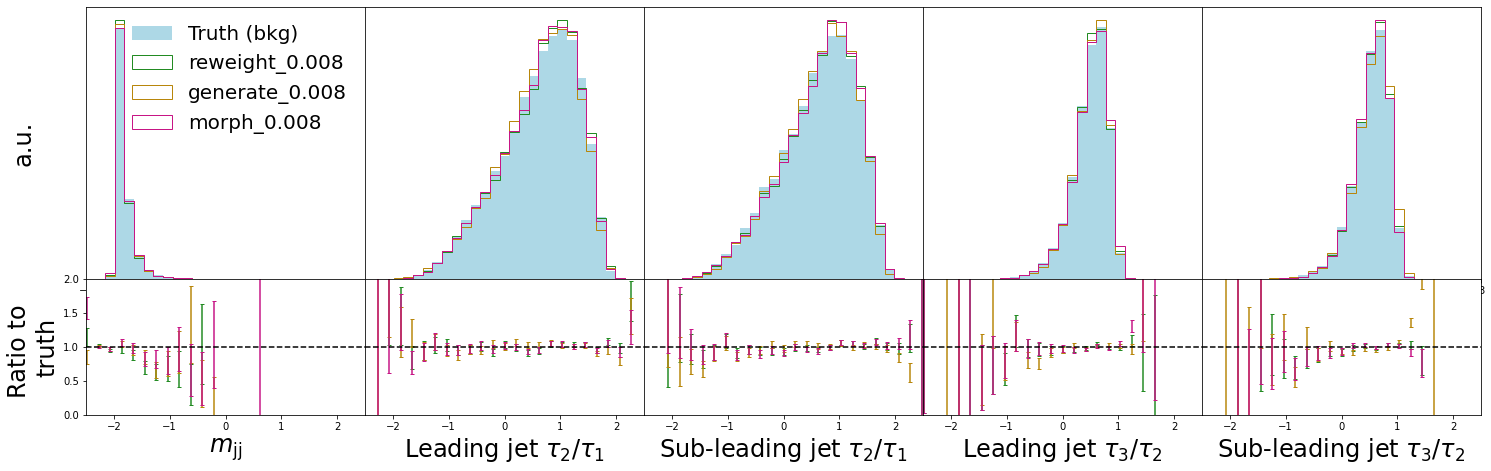

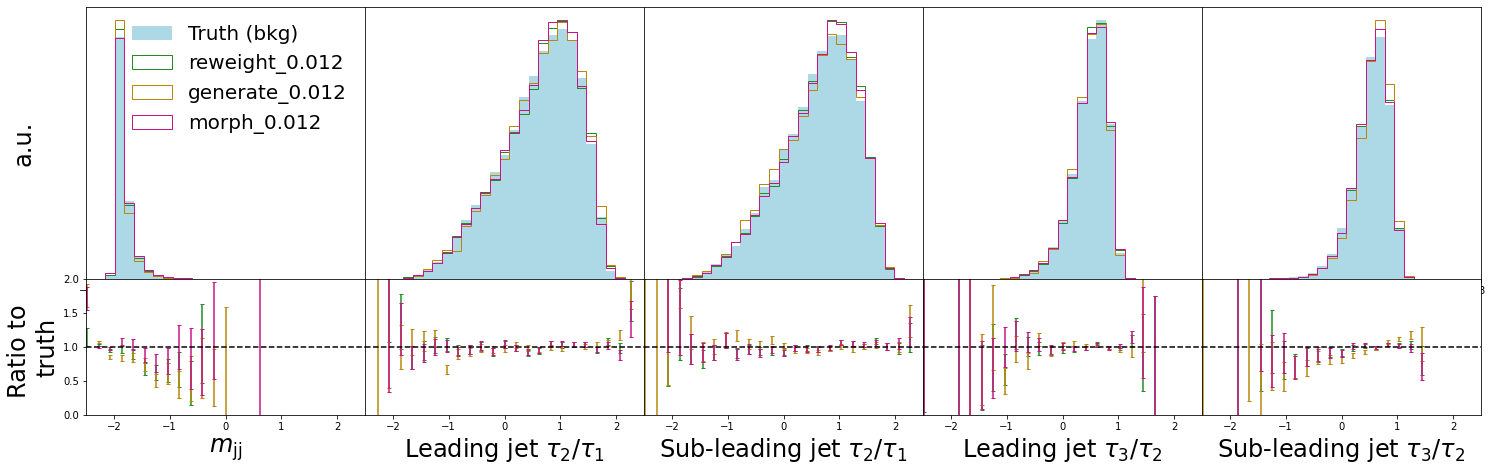

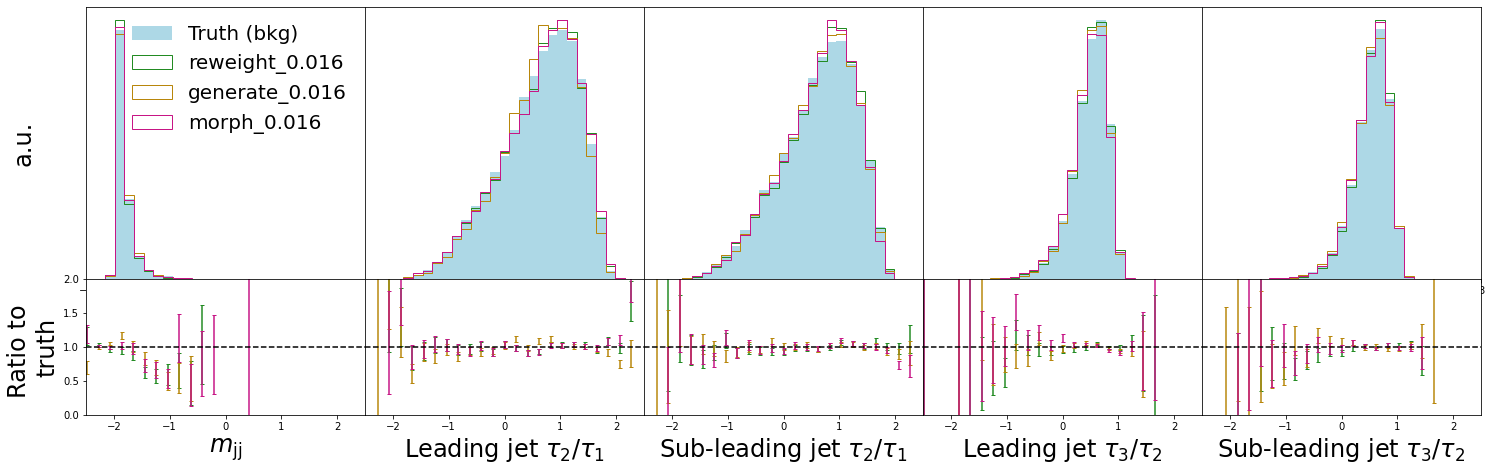

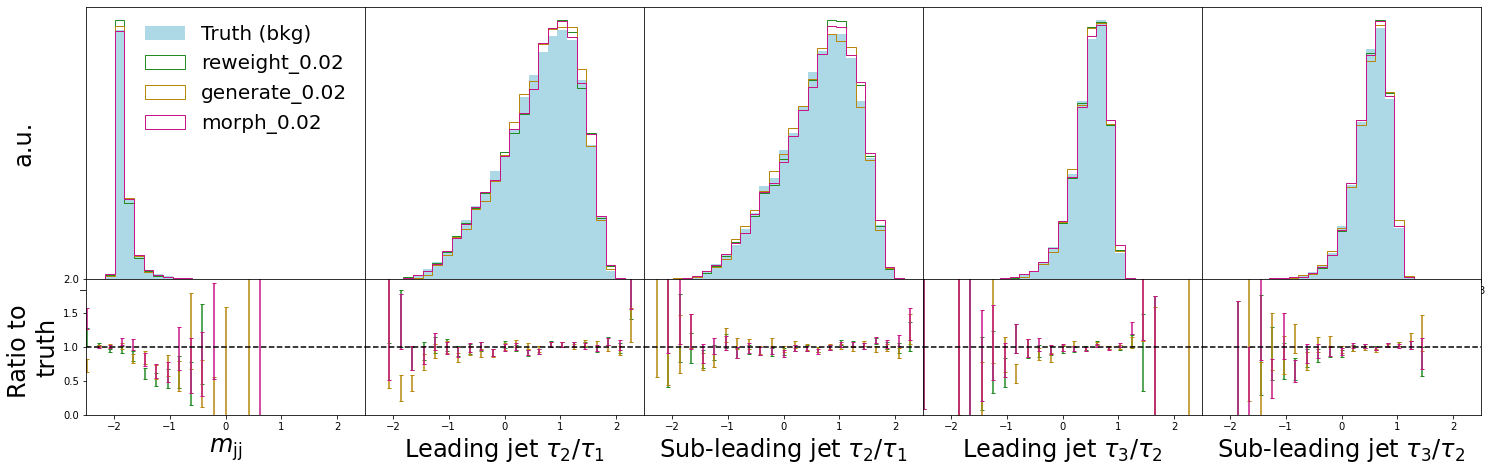

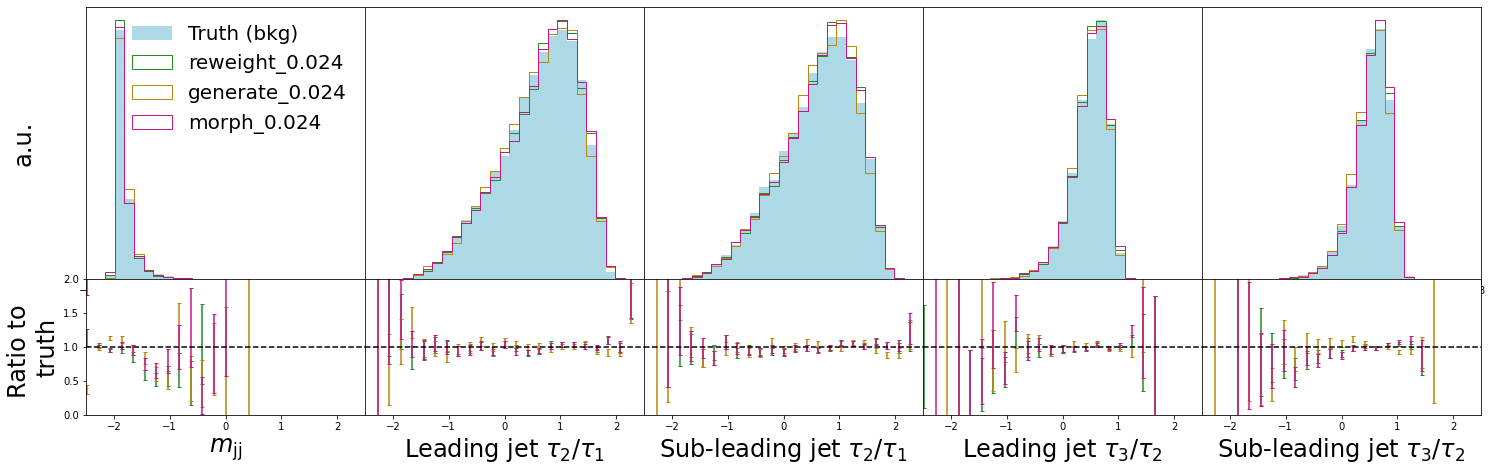

In [12]:
print("CR Closure")
for p in per:
#     keys_to_plot = [f"generate_{p}", f"morph_{p}"]
    keys_to_plot = [f"reweight_{p}", f"generate_{p}",f"morph_{p}"]
    plot_samples(samples_cr_dict, weights_cr_dict, bins, colors_dict, keys_to_plot, xlabel_list, bin_centers, n_features, f1, f2, p)

SR Closure


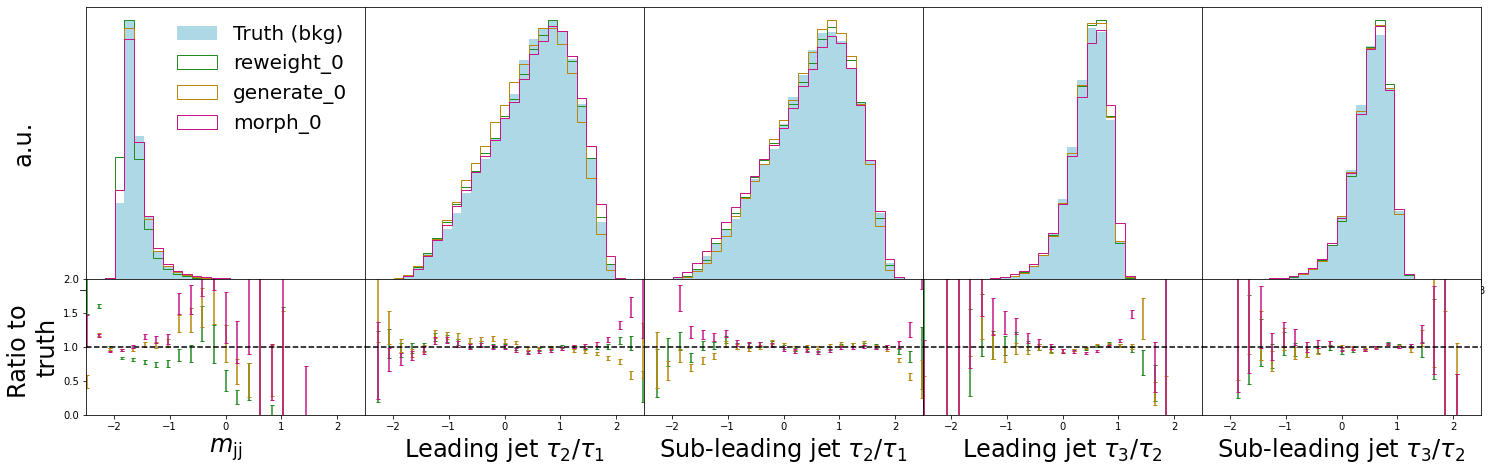

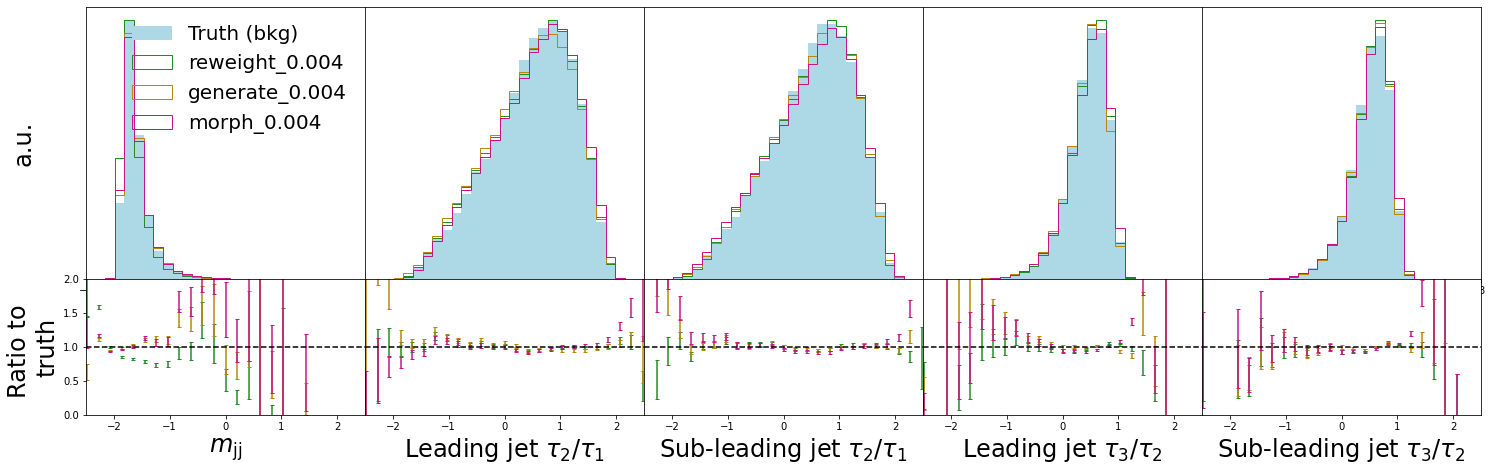

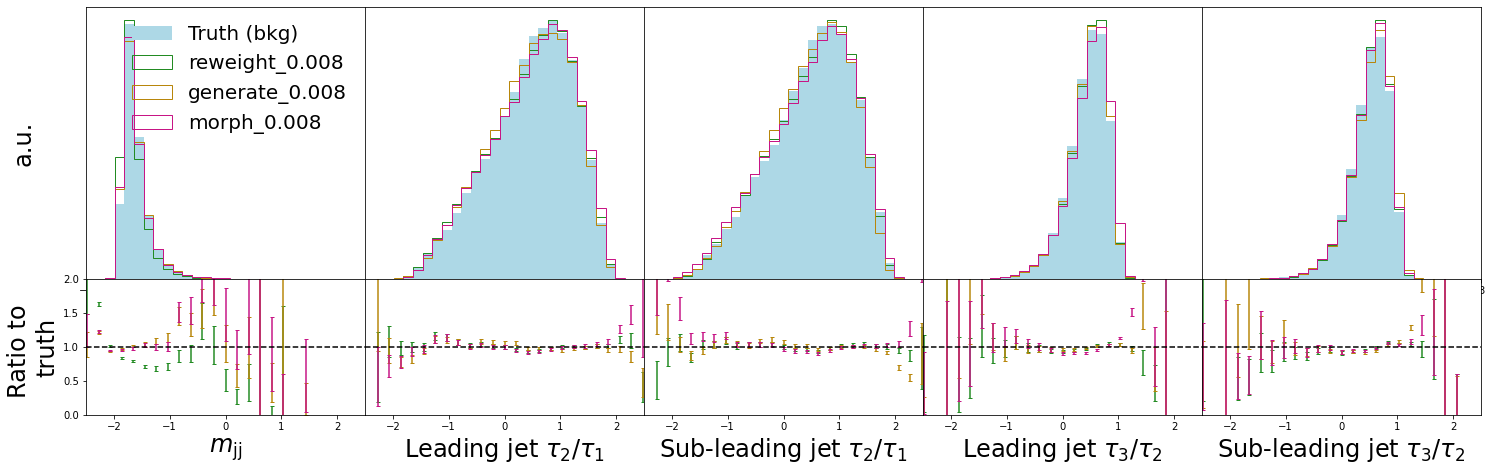

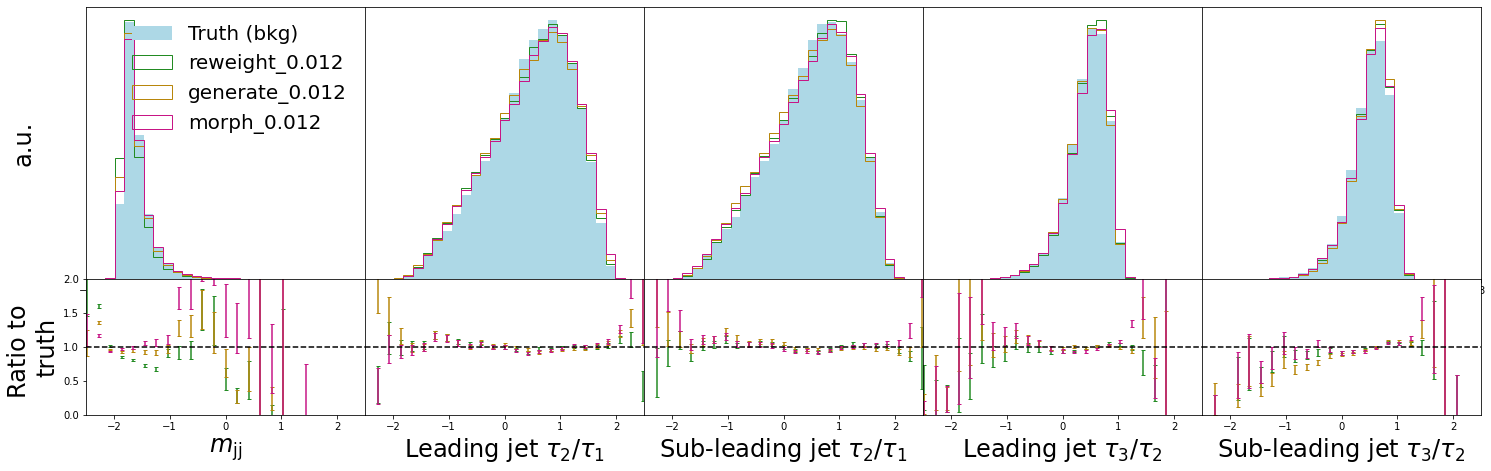

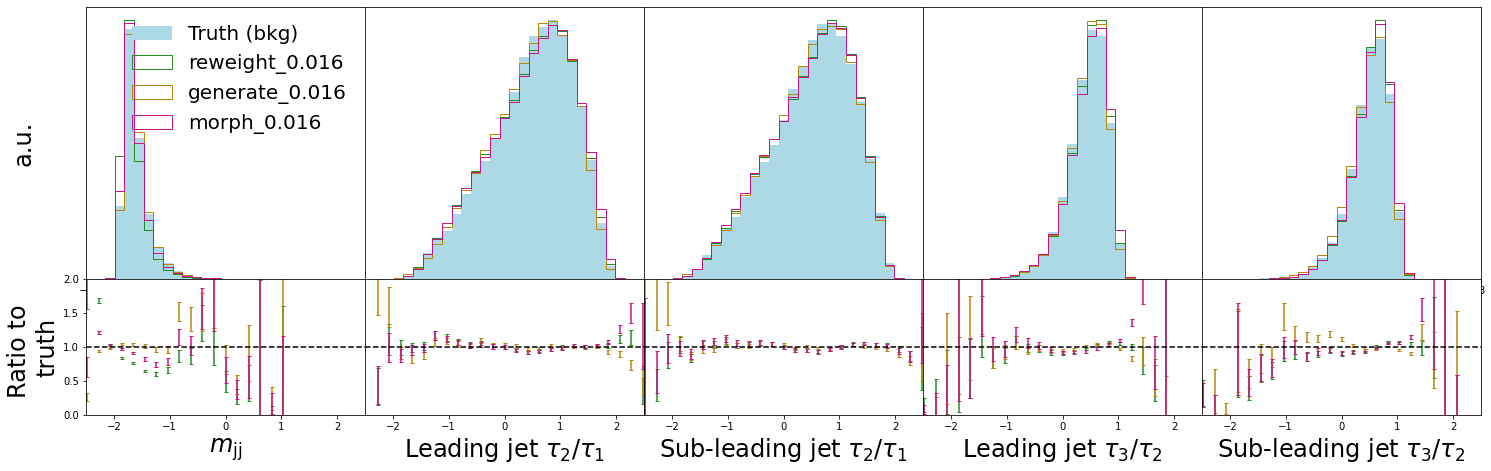

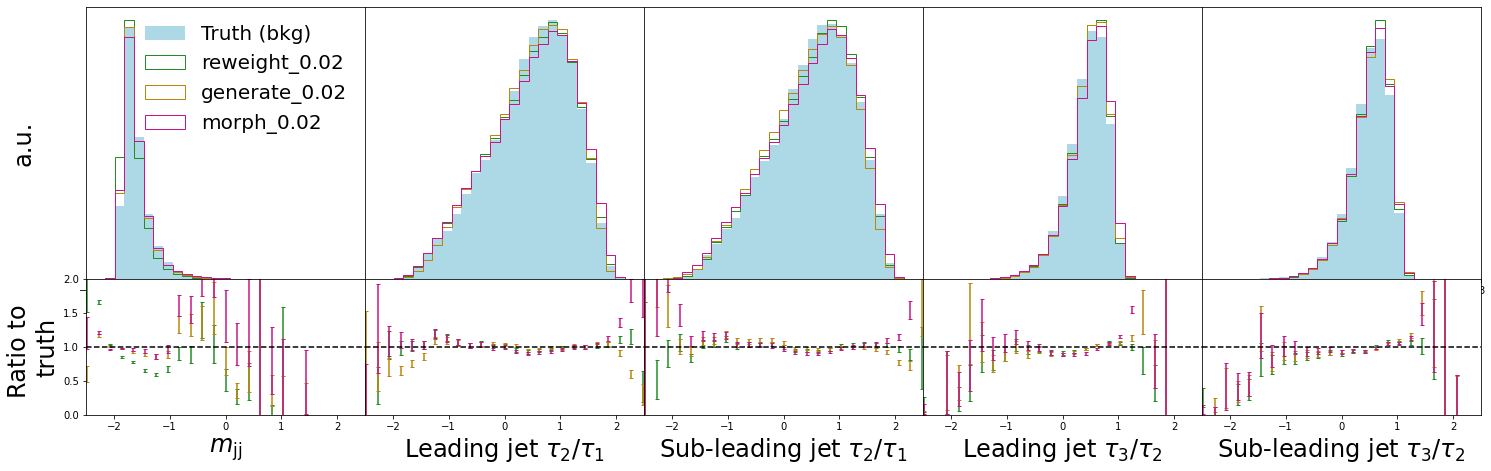

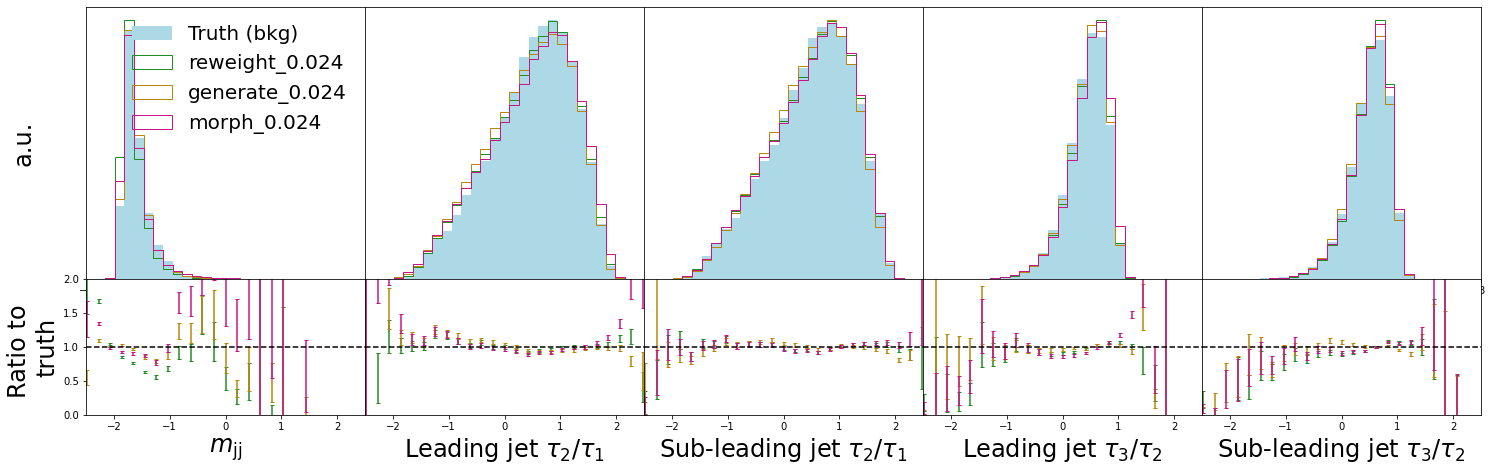

In [13]:
print("SR Closure")
for p in per:
#     keys_to_plot = [f"generate_{p}", f"morph_{p}"]
    keys_to_plot = [f"reweight_{p}", f"generate_{p}",f"morph_{p}"]
    plot_samples(samples_sr_dict, weights_sr_dict, bins, colors_dict, keys_to_plot, xlabel_list, bin_centers, n_features, f1, f2, p)

### Model Metrics

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_wasserstein_distances(distances, models, feature):
    """
    Plots a bar chart of Wasserstein distances for three models, including additional statistics.

    Parameters:
    distances (list of float): Wasserstein distances for three models
    models (list of str): Corresponding model names (should be exactly three)
    """
    if len(models) != 3 or len(distances) != 3:
        raise ValueError("This function is designed for exactly three models.")
    
    # Compute statistics
    avg_distance = np.mean(distances)
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, distances, color=['royalblue', 'seagreen', 'tomato'], alpha=0.85, edgecolor='black', linewidth=1.5)
    
    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel("Wasserstein Distance", fontsize=14, fontweight='bold')
    plt.title(f"Wasserstein Distance Comparison for {feature}", fontsize=16, fontweight='bold')
    
    # Display values inside bars with improved styling
    for bar, value in zip(bars, distances):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                 str(round(value, 3)), ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    
    # Plot average line
    plt.axhline(avg_distance, color='orange', linestyle='dashed', linewidth=2, label=f'Avg: {avg_distance:.3f}')
    # plt.axhline(min_distance, color='gray', linestyle='dotted', linewidth=1.5, label=f'Min: {min_distance:.3f}')
    # plt.axhline(max_distance, color='purple', linestyle='dotted', linewidth=1.5, label=f'Max: {max_distance:.3f}')
    
    # Add legend
    plt.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')
    
    # Beautify the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    plt.show()


In [15]:
#Wasserstein Distance
from scipy.stats import wasserstein_distance
#CR
models = ['reweight', 'generate', 'morph']
var_names = ["m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
wasser_distances_cr = {}
for feature in var_names:
    wasser_distances_cr[f"{feature}_wasdis"] = []
for p in [0]:
    for model in models:
        u_values_all = samples_cr_dict[f"{model}_{p}"][:10000,:].T
        if weights_cr_dict[f"{model}_{p}"] is None: 
            u_weights_all = None
        else:
            u_weights_all = weights_cr_dict[f"{model}_{p}"]
            # u_weights_all = np.repeat(u_weights_all[:, np.newaxis], 5, axis=1)
            # u_weights_all = u_weights_all[:10000, :].T
            u_weights_all = u_weights_all[:10000].reshape(1, -1).repeat(5, axis=0)  # Shape (5, 10000)

        v_values_all = Target_Data[f"{model}_{p}_cr"].T
        for i, feature in enumerate(var_names):
            if u_weights_all is None:
                wasser_distances_cr[f"{feature}_wasdis"].append(wasserstein_distance(u_values = u_values_all[i], v_values = v_values_all[i])/v_values_all[i].std())
            else:
                wasser_distances_cr[f"{feature}_wasdis"].append(wasserstein_distance(u_values = u_values_all[i], v_values = v_values_all[i], u_weights = u_weights_all[i])/v_values_all[i].std())     

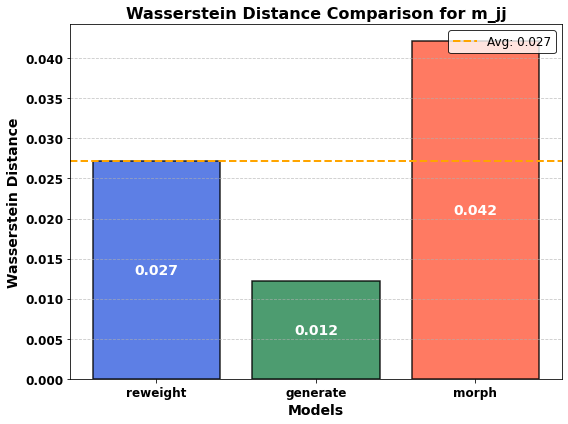

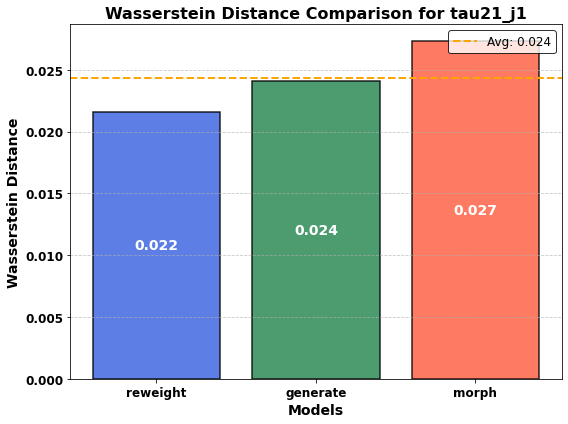

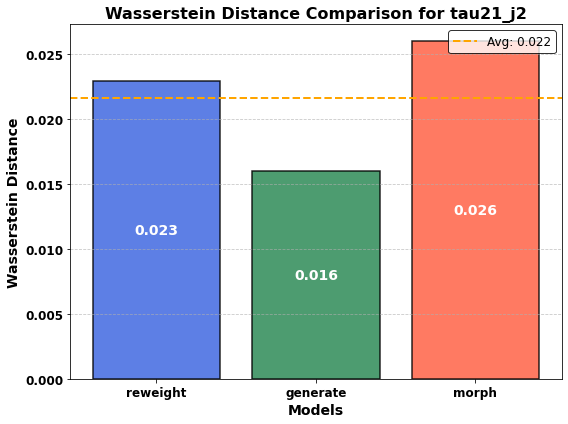

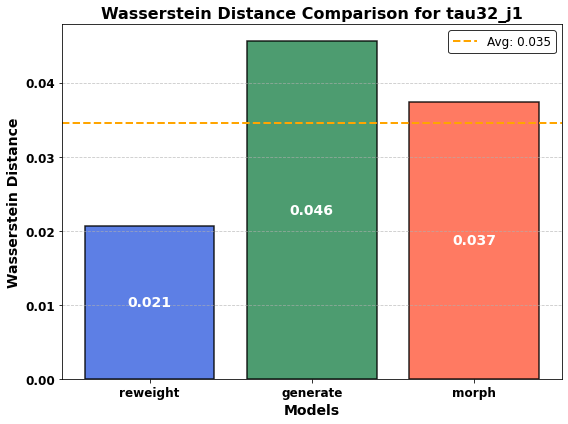

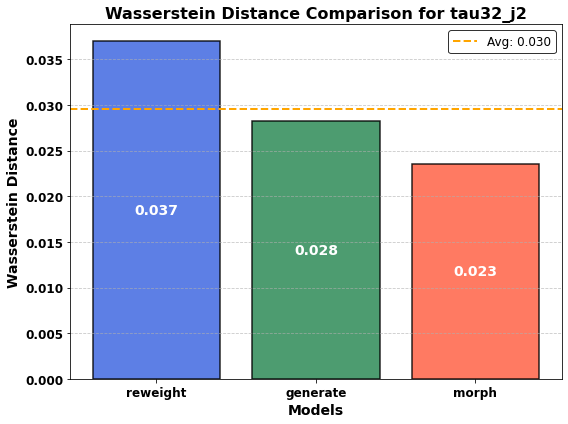

In [16]:
#Plot and Assessments)
for feature in var_names:
    # print(wasser_distances[f"{feature}_wasdis"])
    plot_wasserstein_distances(wasser_distances_cr[f"{feature}_wasdis"], models, feature)


In [17]:
#SR
models = ['reweight', 'generate', 'morph']
# for model in models:
wasser_distances_sr = {}
for feature in var_names:
    wasser_distances_sr[f"{feature}_wasdis"] = []
for p in [0]:
    for model in models:
        u_values_all = samples_sr_dict[f"{model}_{p}"][:10000,:].T
        if weights_sr_dict[f"{model}_{p}"] is None: 
            u_weights_all = None
        else:
            u_weights_all = weights_sr_dict[f"{model}_{p}"]
            # u_weights_all = np.repeat(u_weights_all[:, np.newaxis], 5, axis=1)
            # u_weights_all = u_weights_all[:10000, :].T
            u_weights_all = u_weights_all[:10000].reshape(1, -1).repeat(5, axis=0)  # Shape (5, 10000)

        v_values_all = Target_Data[f"{model}_{p}_sr"].T
        for i, feature in enumerate(var_names):
            if u_weights_all is None:
                wasser_distances_sr[f"{feature}_wasdis"].append(wasserstein_distance(u_values = u_values_all[i], v_values = v_values_all[i])/v_values_all[i].std())
            else:
                wasser_distances_sr[f"{feature}_wasdis"].append(wasserstein_distance(u_values = u_values_all[i], v_values = v_values_all[i], u_weights = u_weights_all[i])/v_values_all[i].std())
        
        

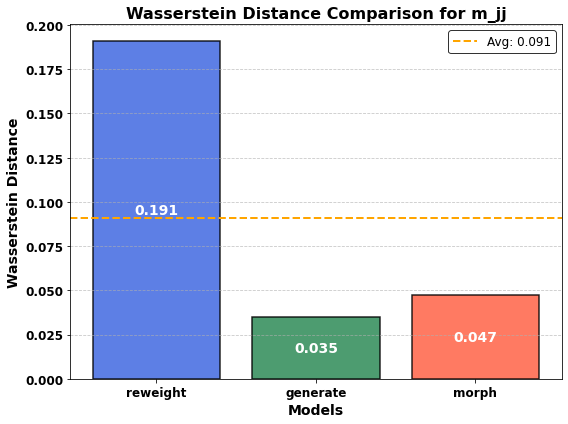

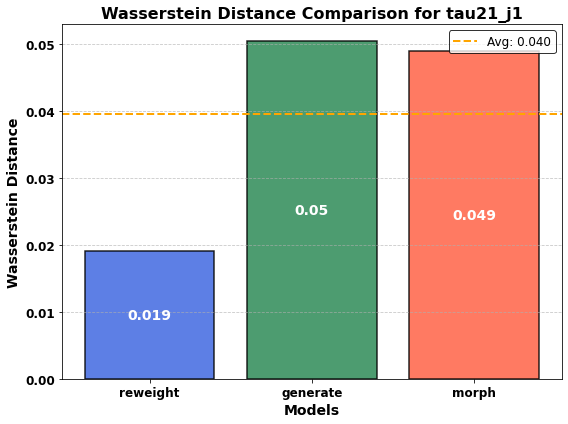

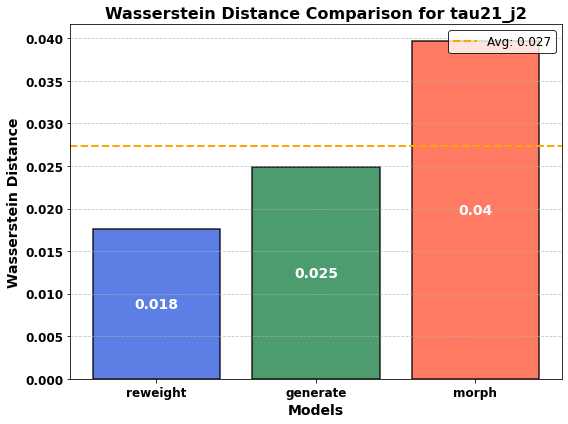

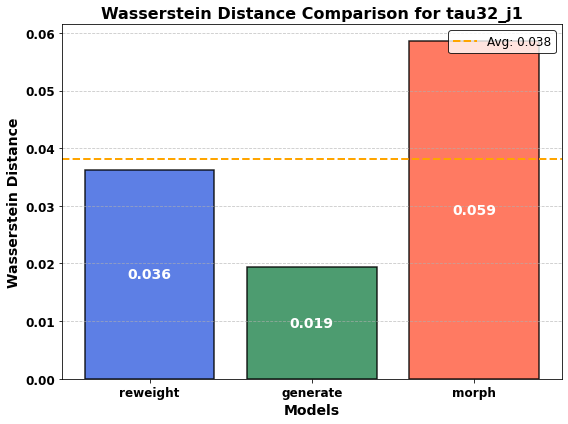

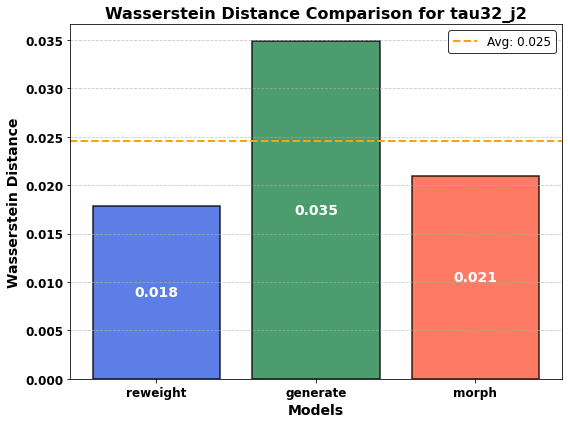

In [18]:
#Plot and Assessments)
for feature in var_names:
    # print(wasser_distances[f"{feature}_wasdis"])
    plot_wasserstein_distances(wasser_distances_sr[f"{feature}_wasdis"], models, feature)


### CwoLa Training

In [19]:
def plot_CWoLa_loss(train_losses, val_losses, title):

    # Create a figure with two subplots (side by side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot train losses on the left axis
    for i, train in enumerate(train_losses):
        epochs_train = np.arange(1, len(train) + 1)
        ax1.plot(epochs_train, train, label=f'Train Loss (Run {i+1})', alpha=0.7)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Train Loss (All Runs)')
    ax1.grid(True)
    ax1.legend()

    # Plot validation losses on the right axis
    for i, val in enumerate(val_losses):
        epochs_val = np.arange(1, len(val) + 1)
        ax2.plot(epochs_val, val, label=f'Validation Loss (Run {i+1})', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Validation Loss (All Runs)')
    ax2.grid(True)
    ax2.legend()
    fig.suptitle(title)
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [20]:
gen_seed = 1
n_classifier = 20
# Load Data
models = ['reweight', 'generate', 'morph']
# Loss Path
loss_path = f"{working_dir}/evaluation/seed{gen_seed}"
loss_data = {}
train_loss = {}
val_loss = {}
for p in [0]:
    for model in models:
        for i in range(n_classifier):
            loss_data[f"{model}_loss_{p}_cr_run{i}"] = np.load(f"{loss_path}/loss_data/model_{model}_{p}_cr_run{i}_loss.npz")
            loss_data[f"{model}_loss_{p}_sr_run{i}"] = np.load(f"{loss_path}/loss_data/model_{model}_{p}_sr_run{i}_loss.npz")
            train_loss[f"{model}_tloss_{p}_cr_run{i}"] = loss_data[f"{model}_loss_{p}_cr_run{i}"]["train_loss"]
            val_loss[f"{model}_vloss_{p}_cr_run{i}"] = loss_data[f"{model}_loss_{p}_cr_run{i}"]["val_loss"]
            train_loss[f"{model}_tloss_{p}_sr_run{i}"] = loss_data[f"{model}_loss_{p}_sr_run{i}"]["train_loss"]
            val_loss[f"{model}_vloss_{p}_sr_run{i}"] = loss_data[f"{model}_loss_{p}_sr_run{i}"]["val_loss"]
            

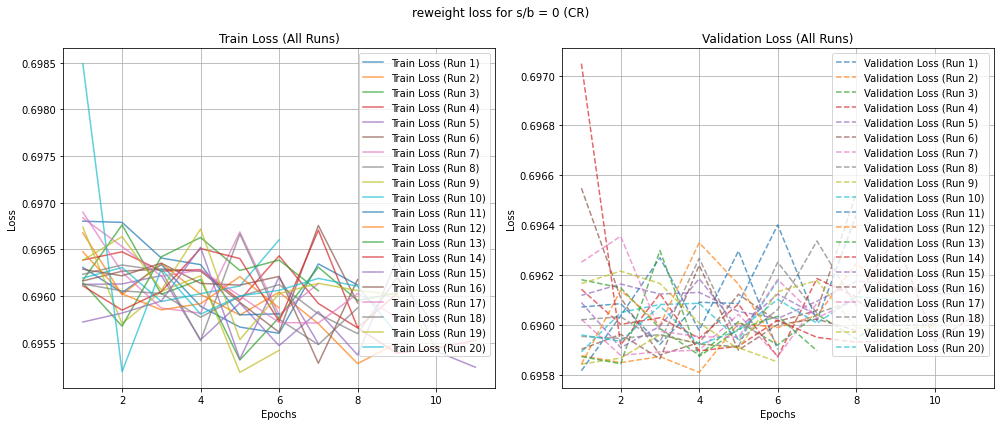

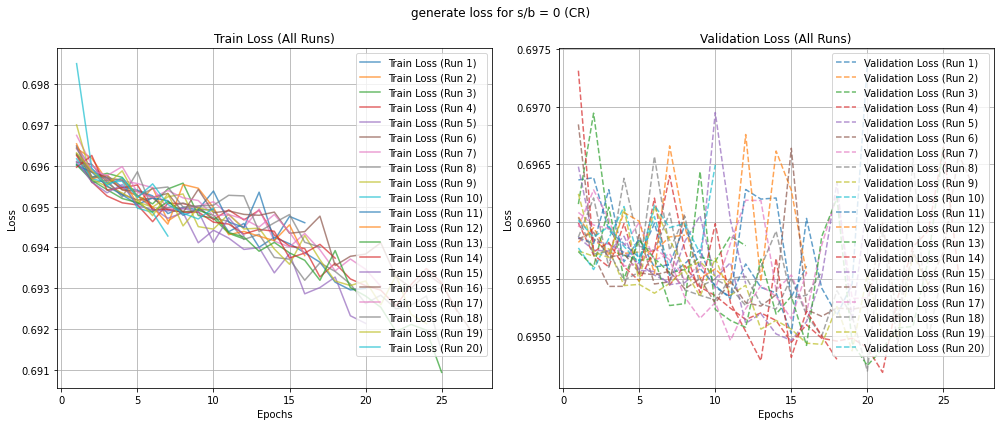

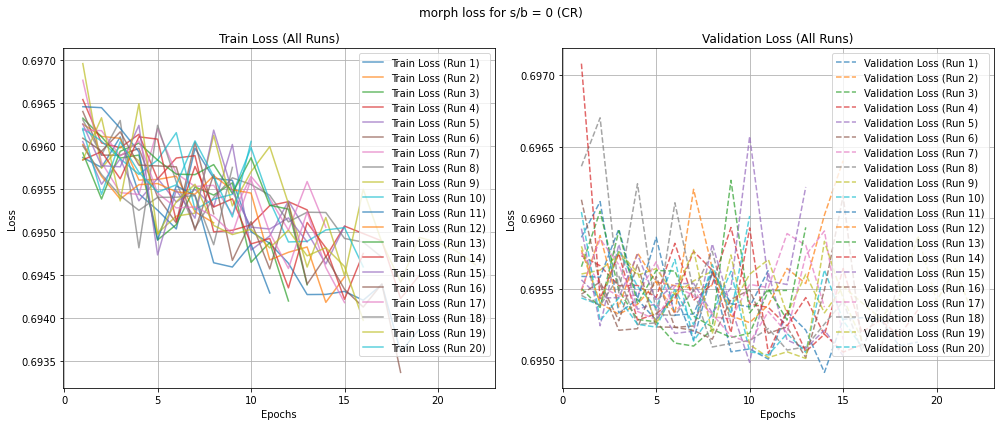

In [21]:
# CR
for p in [0]:
    for model in models:
        train_losses = []
        val_losses = []
        for i in range(n_classifier):
            train_losses.append(train_loss[f"{model}_tloss_{p}_cr_run{i}"])
            val_losses.append(val_loss[f"{model}_vloss_{p}_cr_run{i}"])
            
#         train_losses = np.array(train_losses)
#         print(train_losses)
        plot_CWoLa_loss(train_losses, val_losses, f"{model} loss for s/b = {p} (CR)")    


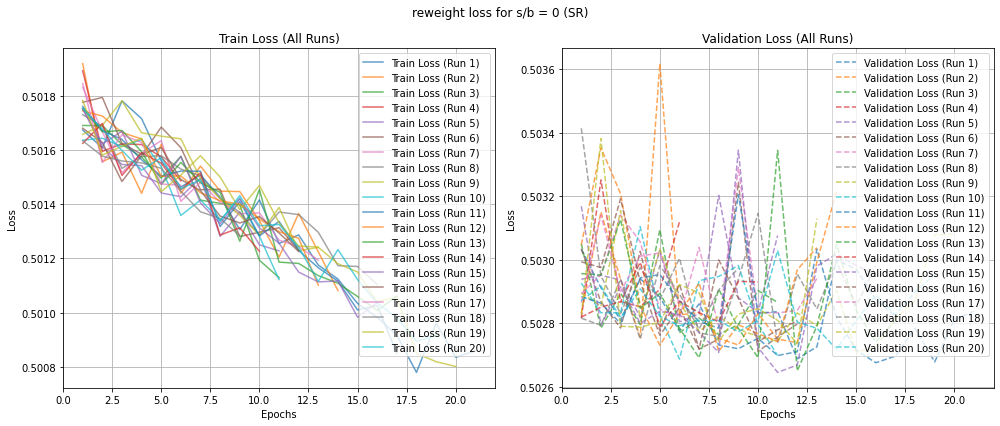

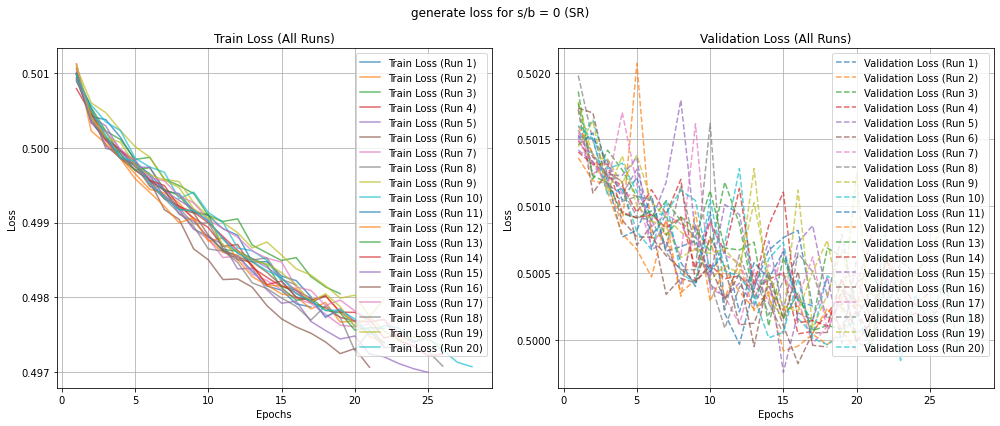

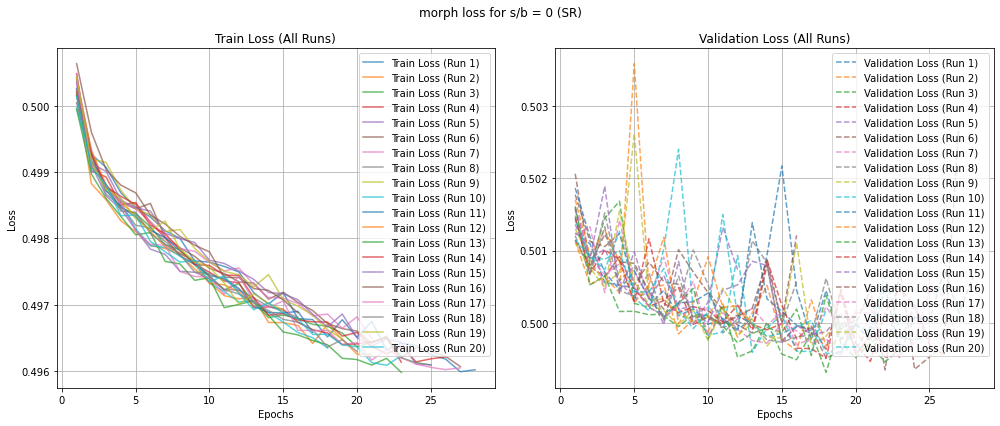

In [22]:
# SR
for p in [0]:
    for model in models:
        train_losses = []
        val_losses = []
        for i in range(n_classifier):
            train_losses.append(train_loss[f"{model}_tloss_{p}_sr_run{i}"])
            val_losses.append(val_loss[f"{model}_vloss_{p}_sr_run{i}"])
            
#         train_losses = np.array(train_losses)
#         print(train_losses)
        plot_CWoLa_loss(train_losses, val_losses, f"{model} loss for s/b = {p} (SR)")    


### CWoLa Model Metrics

In [23]:
# load in test events
test_events = np.load(f"{working_dir}/data/test_SR.npz")
test_bkg = test_events["bkg_events_SR"][:,n_context:]
test_sig = test_events["sig_events_SR"][:,n_context:]


input_x_test = np.concatenate([test_bkg, test_sig], axis=0)
input_y_test = np.concatenate([np.zeros(test_bkg.shape[0]).reshape(-1,1), np.ones(test_sig.shape[0]).reshape(-1,1)], axis=0)

In [24]:
#Get s/b in SR
gen_seed = 1
data_path = f"{working_dir}/data/seed{gen_seed}"
eval_dir = f"{working_dir}/evaluation/"
data = {}
sig_inj_labels = []
significances = []
for p in per:
    data_file = np.load(f"{data_path}/data_{p}.npz")
    sig_inj_labels.append(data_file['sig_percent'].tolist())
    # print(type(data_file['sig_percent'].tolist()))
    significances.append(data_file['signif'].tolist())
    print(data_file['signif'].tolist())
    

0.0
0.87406
1.69233
2.57382
3.54831
4.3703
5.26295


In [25]:
# Initialize
keys = ["reweight", "generate", "morph"]
rejections_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}                
sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
rocs_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
max_sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
sic_at_rej1_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
sic_at_rej2_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
auc_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}

rejection1_for_sic = 1000
rejection2_for_sic = 10000

x_axis = np.logspace(-5, 0, 100)
x_axis_roc = np.linspace(0, 1, 100)

In [26]:
# Process 
per = [0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024]
threshold_data = {}
sic_data = {}
sig_inj_seeds = [1, 2, 3, 4]
for i, sig in enumerate(per):
    sig_label = sig_inj_labels[i]
    print(f"Evaluating s/b = {sig}")

    for k in keys:
        print(f"=={k}==")
        for seed in sig_inj_seeds:
            scores_to_ensemble = []

            n_classifier = 10
            for x in range(n_classifier):
                model_dir = f"{eval_dir}/seed{seed}/"
                local_id = f"{k}_{sig}_sr_run{x}"

                # Load Model
                model_path = f"{model_dir}/model_{local_id}.pt"
                model_ML = torch.load(model_path, weights_only=False)

                scores = model_ML.evaluation(input_x_test)
                scores_to_ensemble.append(scores)
            
            avg_scores = np.mean(scores_to_ensemble, axis = 0)
            fpr, tpr, threshold = roc_curve(input_y_test, avg_scores)
            
            fpr_nonzero_indices = np.where(fpr != 0) # Blow up th rejection
            fpr_nonzero = fpr[fpr_nonzero_indices]
            tpr_nonzero = tpr[fpr_nonzero_indices]
            rejection = 1.0 / fpr_nonzero 
            sic = tpr_nonzero / np.sqrt(fpr_nonzero)
            sic_data[f"sic_{k}_seed{seed}_p{sig}"] = sic

            # MAX SIC
            eps_bkg = 1.0/((0.4**2)*(test_bkg.shape[0]))
            fpr_cutoff_indices = np.where(fpr_nonzero > eps_bkg)
            maxsic = np.nanmax(sic[fpr_cutoff_indices])
            # print(seed)
            threshold_data[f"th_{k}_{sig}_{seed}"] = threshold[np.argmax(sic)]
            
            # calculate the sic at the desired rejection rejection_for_sic
            for ind in range(len(rejection)):
                if (rejection[ind] >= rejection1_for_sic) and (rejection[ind+1] < rejection1_for_sic):
                    sic_at_rejection1 = sic[ind]
                if (rejection[ind] >= rejection2_for_sic) and (rejection[ind+1] < rejection2_for_sic):
                    sic_at_rejection2 = sic[ind]
            
            interp_sic = np.interp(x_axis, tpr_nonzero, sic)
            interp_rej = np.interp(x_axis, tpr_nonzero, rejection)
            interp_roc = np.interp(x_axis_roc, fpr, tpr)
    
            rejections_dict[k][sig_label].append(interp_rej)
            sics_dict[k][sig_label].append(interp_sic)
            rocs_dict[k][sig_label].append(interp_roc)
    
            max_sics_dict[k][sig_label].append(maxsic)
            # print(k, maxsic, f"seed {seed}")
            sic_at_rej1_dict[k][sig_label].append(sic_at_rejection1)
            sic_at_rej2_dict[k][sig_label].append(sic_at_rejection2)

Evaluating s/b = 0
==reweight==
==generate==
==morph==
Evaluating s/b = 0.004
==reweight==
==generate==
==morph==
Evaluating s/b = 0.008
==reweight==
==generate==
==morph==
Evaluating s/b = 0.012
==reweight==
==generate==
==morph==
Evaluating s/b = 0.016
==reweight==
==generate==
==morph==
Evaluating s/b = 0.02
==reweight==
==generate==
==morph==
Evaluating s/b = 0.024
==reweight==
==generate==
==morph==


#### Graph SIC

In [27]:
def plot_sic_curve(x_axis, sic_curve, x_label="Signal Efficiency (TPR)", title="SIC Curve", seed_label=""):
    """
    Plots a single SIC curve, highlights max SIC, and optionally SIC at 80% efficiency.

    Parameters:
    - x_axis: 1D NumPy array representing the common x-axis values (e.g., signal efficiency).
    - sic_curve: 1D NumPy array representing SIC values at the x-axis points.
    - x_label: Label for the x-axis (default: "Signal Efficiency (TPR)").
    - title: Title for the plot (default: "SIC Curve").
    - seed_label: Optional label for the specific seed (e.g., "Seed 1").

    Returns:
    - None (displays the plot)
    """

    # Find Maximum SIC
    max_sic_index = np.argmax(sic_curve)
    max_sic_value = sic_curve[max_sic_index]
    max_sic_x = x_axis[max_sic_index]

    # Choose a target x-axis value (e.g., 80% signal efficiency)
    target_x = 0.8  
    if min(x_axis) <= target_x <= max(x_axis):
        idx = np.argmin(np.abs(x_axis - target_x))
        sic_at_target = sic_curve[idx]
    else:
        sic_at_target = None

    # 📊 PLOTTING
    plt.figure(figsize=(8, 6))
    plt.plot(x_axis, sic_curve, linestyle='solid', color='blue', linewidth=2, label=f"SIC {seed_label}")

    # Highlight SIC at Target x-axis Value (e.g., 80% TPR)
    if sic_at_target is not None:
        plt.scatter(target_x, sic_at_target, color='black', label=f"SIC at {target_x:.2f}: {sic_at_target:.2f}", s=100, marker='o')

    # Highlight Maximum SIC
    plt.scatter(max_sic_x, max_sic_value, color='red', label=f"Max SIC: {max_sic_value:.2f}", s=100, marker='x')

    # Formatting
    plt.xlabel(x_label)
    plt.ylabel("SIC Value")
    plt.title(f"{title} {seed_label}")
    plt.legend()
    plt.grid(True)
    plt.show()


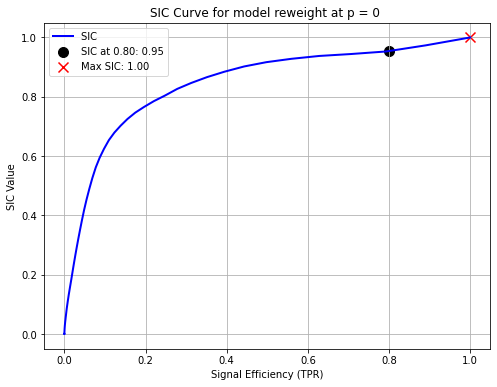

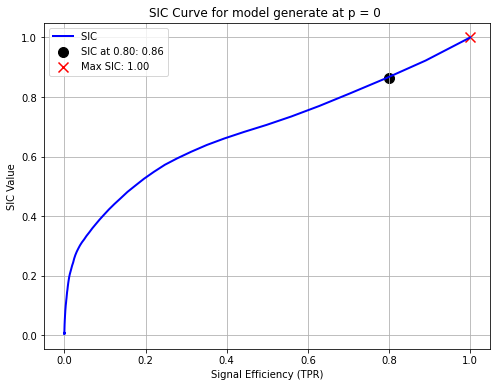

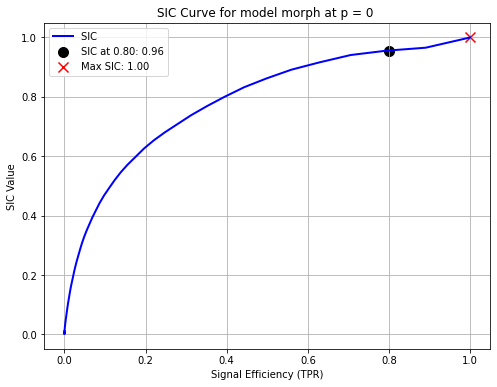

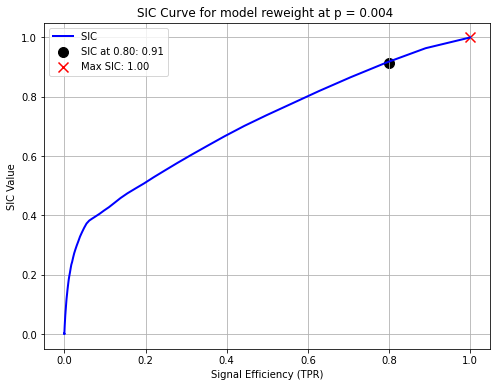

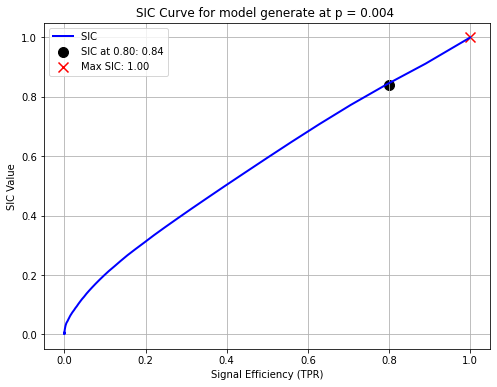

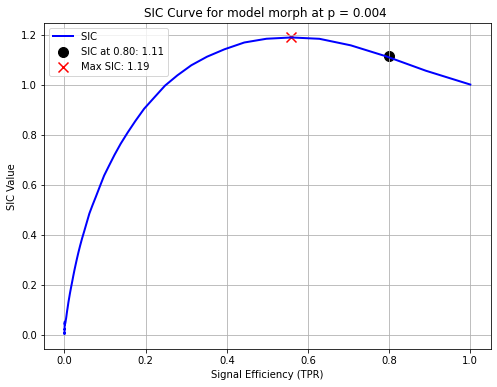

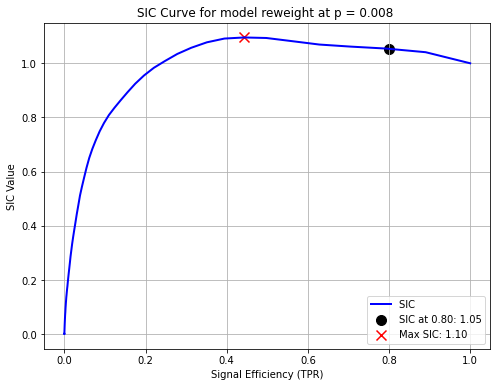

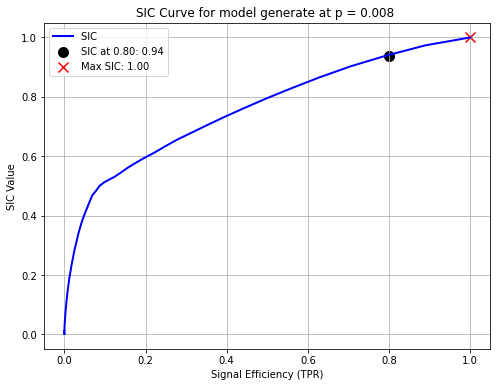

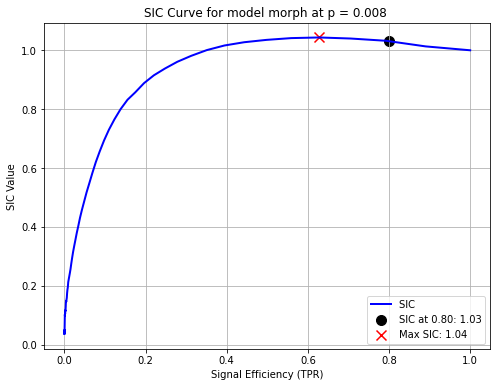

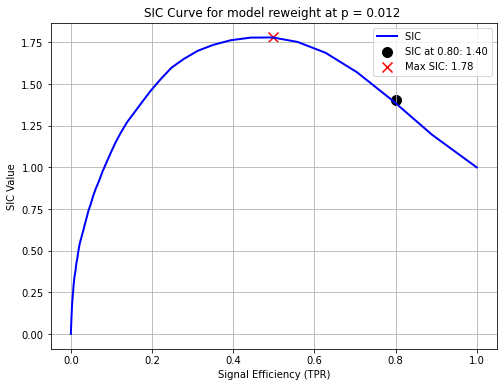

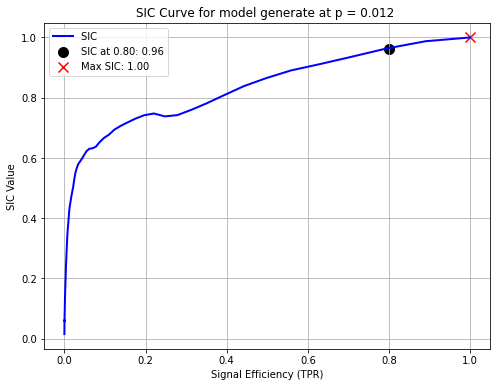

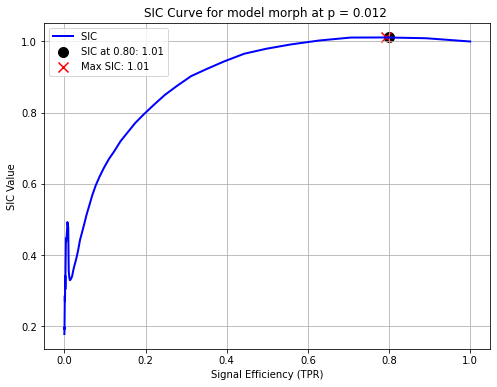

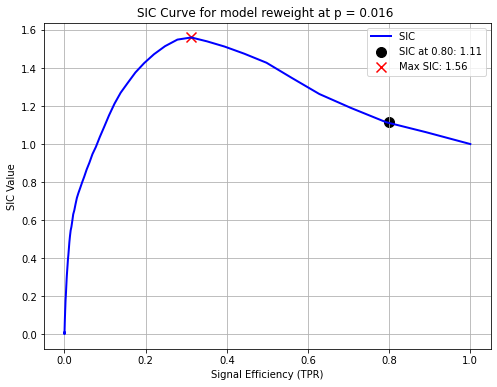

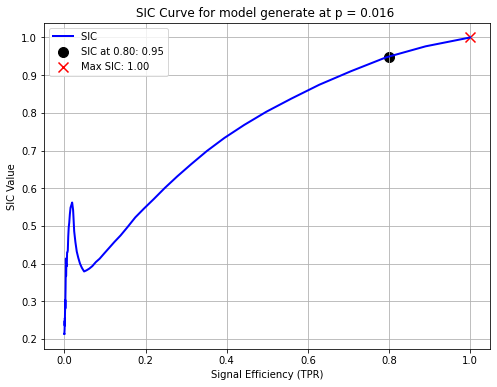

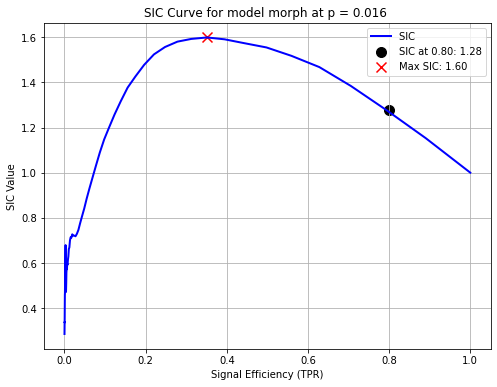

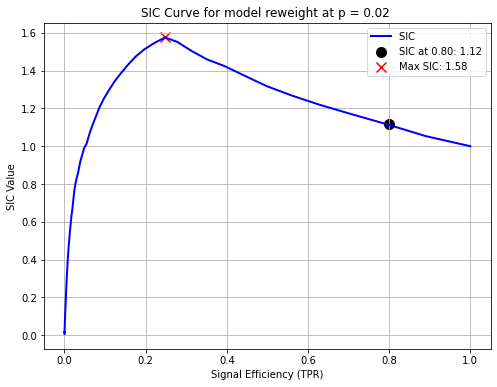

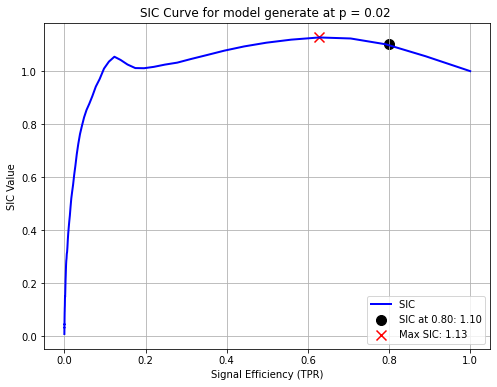

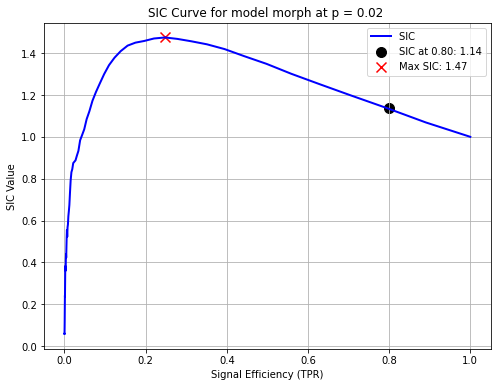

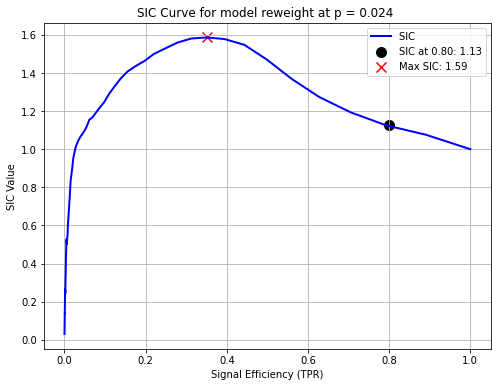

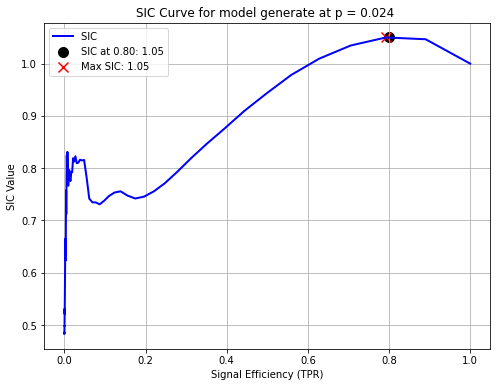

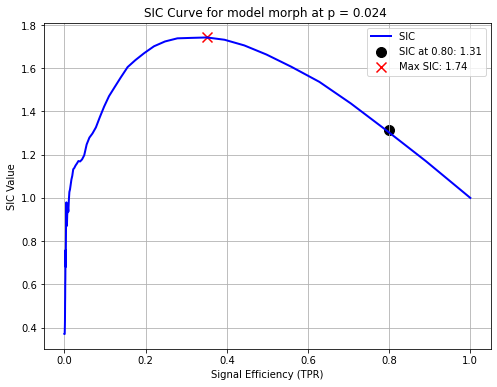

In [28]:
# print(sics_dict)
# for sig_l in sig_inj_labels:
#     for model in ['reweight']:
#         print(len(sics_dict[model][sig_l]))

averaged_data_sic = {
    key: {sub_key: np.mean(values, axis = 0) for sub_key, values in sub_dict.items()}
    for key, sub_dict in sics_dict.items()
}

# print(averaged_data_sic)
for i, p in enumerate(per):
    for model in ['reweight', 'generate', 'morph']:
        plot_sic_curve(x_axis, averaged_data_sic[model][sig_inj_labels[i]], title = f"SIC Curve for model {model} at p = {p}")
        # print(averaged_data_sic[model][sig_l].shape)
        # print(x_axis.shape)

In [29]:
# print(max_sics_dict)
averaged_data_max_sic = {
    key: {sub_key: np.mean(values) for sub_key, values in sub_dict.items()}
    for key, sub_dict in max_sics_dict.items()
}

print(averaged_data_max_sic)

{'reweight': {0.0: 1.0, 0.00325: 1.0011867014403142, 0.00629: 1.2002903343213809, 0.00957: 1.8221376710759236, 0.0132: 1.5631718410138522, 0.01625: 1.5951919058281119, 0.01958: 1.6626540537082715}, 'generate': {0.0: 1.0, 0.00325: 1.0000010321856116, 0.00629: 1.013312440584715, 0.00957: 1.0658217851603111, 0.0132: 1.1003042701142831, 0.01625: 1.2430315004126593, 0.01958: 1.1681171645423474}, 'morph': {0.0: 1.0, 0.00325: 1.2551811484228368, 0.00629: 1.0741214597913804, 0.00957: 1.0597725807422869, 0.0132: 1.6395945347597458, 0.01625: 1.4901585567457953, 0.01958: 1.7894461438982399}}


In [30]:
pickle.dump( rejections_dict, open( f"pickles/rejections_dict.p", "wb" ) )
pickle.dump( sics_dict, open( f"pickles/sics_dict.p", "wb" ) )
pickle.dump( rocs_dict, open( f"pickles/rocs_dict.p", "wb" ) )
pickle.dump( max_sics_dict, open( f"pickles/max_sics_dict.p", "wb" ) )
pickle.dump( sic_at_rej1_dict, open( f"pickles/sic_at_rej1_dict.p", "wb" ) )
pickle.dump( sic_at_rej2_dict, open( f"pickles/sic_at_rej2_dict.p", "wb" ) )
pickle.dump( auc_dict, open( f"pickles/auc_dict.p", "wb" ) )

In [31]:
def get_med_percentile(loc_list, lower_p = 16, upper_p = 84):
    
    med = np.nanmedian(loc_list, axis = 0)
    lower_p  = np.nanpercentile(loc_list, lower_p, axis = 0)
    upper_p = np.nanpercentile(loc_list, upper_p, axis = 0)
    
    return med, lower_p, upper_p

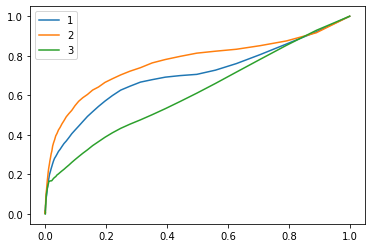

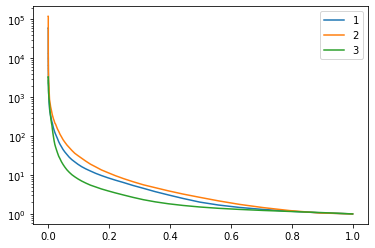

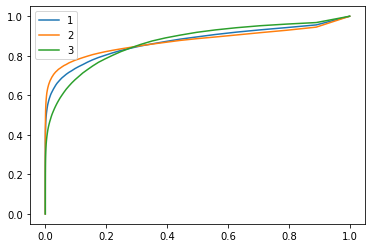

In [32]:
ss = 0
kk = "generate"

plt.figure()
for i in range(0, 3):
    plt.plot(x_axis, sics_dict[kk][ss][i], label = i+1)
plt.legend()
plt.show()

plt.figure()
for i in range(0, 3):
    plt.plot(x_axis, rejections_dict[kk][ss][i], label = i+1)
plt.legend()
plt.yscale("log")
plt.show()


plt.figure()
for i in range(0, 3):
    plt.plot(x_axis, rocs_dict[kk][ss][i], label = i+1)
plt.legend()
plt.show()

In [34]:
# Take medians
med_rejections_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_sics_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_rocs_dict = {k:{s:[] for s in sig_inj_labels} for k in keys}
med_max_sics_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys} # mean, lower_p, upper_p
med_sics_at_rej1_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}
med_sics_at_rej2_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}

for s in sig_inj_labels:
    
    for k in keys:

        med_rejections_dict[k][s] = get_med_percentile(rejections_dict[k][s])
        med_sics_dict[k][s] = get_med_percentile(sics_dict[k][s])
        med_rocs_dict[k][s] = get_med_percentile(rocs_dict[k][s])
                 
        # max sic sic at rejection are single numbers, not arrays
        med_max_sics_dict[k][0] = np.append(med_max_sics_dict[k][0], np.median(max_sics_dict[k][s]))
        med_max_sics_dict[k][1] = np.append(med_max_sics_dict[k][1], np.percentile(max_sics_dict[k][s], 16)) 
        med_max_sics_dict[k][2] = np.append(med_max_sics_dict[k][2], np.percentile(max_sics_dict[k][s], 84))        
            
        med_sics_at_rej1_dict[k][0] = np.append(med_sics_at_rej1_dict[k][0], np.median(sic_at_rej1_dict[k][s]))
        med_sics_at_rej1_dict[k][1] = np.append(med_sics_at_rej1_dict[k][1], np.percentile(sic_at_rej1_dict[k][s], 16))
        med_sics_at_rej1_dict[k][2] = np.append(med_sics_at_rej1_dict[k][2], np.percentile(sic_at_rej1_dict[k][s], 84))
        med_sics_at_rej2_dict[k][0] = np.append(med_sics_at_rej2_dict[k][0], np.median(sic_at_rej2_dict[k][s]))
        med_sics_at_rej2_dict[k][1] = np.append(med_sics_at_rej2_dict[k][1], np.percentile(sic_at_rej2_dict[k][s], 16))
        med_sics_at_rej2_dict[k][2] = np.append(med_sics_at_rej2_dict[k][2], np.percentile(sic_at_rej2_dict[k][s], 84))

In [35]:
# Plotting params

colors_dict = {"full_sup":"grey",
               "reweight": "forestgreen",
               "morph": "mediumvioletred",
               "generate":"darkgoldenrod",
                "ideal":"darkblue"}


labels_dict = {"full_sup":"Fully Supervised",
               "reweight": "Reweight",
               "morph": "Morph",
               "generate":"Generate",
              "ideal": "Ideal"}


l = 3
f1 = 24
f2 = 16

alpha = 0.4

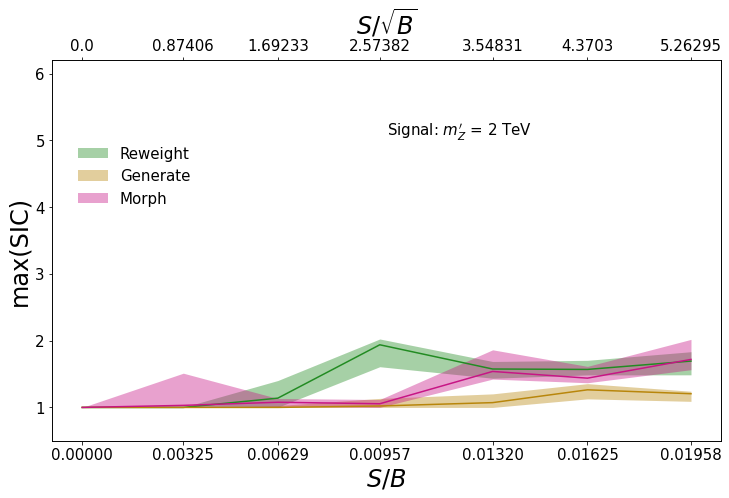

In [36]:
f1 = 24
f2 = 15


fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:  
    ax1.plot(sig_inj_labels, med_max_sics_dict[k][0], color = colors_dict[k])   
    ax1.fill_between(sig_inj_labels, med_max_sics_dict[k][1],
                        med_max_sics_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj_labels]).reshape(len(sig_inj_labels),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = (.03,.6))
ax1.set_ylabel("max(SIC)", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj_labels, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

#plt.ylim(0,21)
plt.ylim(0.5, 6.2)
plt.text(0.5, 0.8, "Signal: $m_Z'$ = 2 TeV", fontsize=f2, transform=plt.gca().transAxes)
fig.savefig(f"plots/maxsic.pdf")

plt.show()

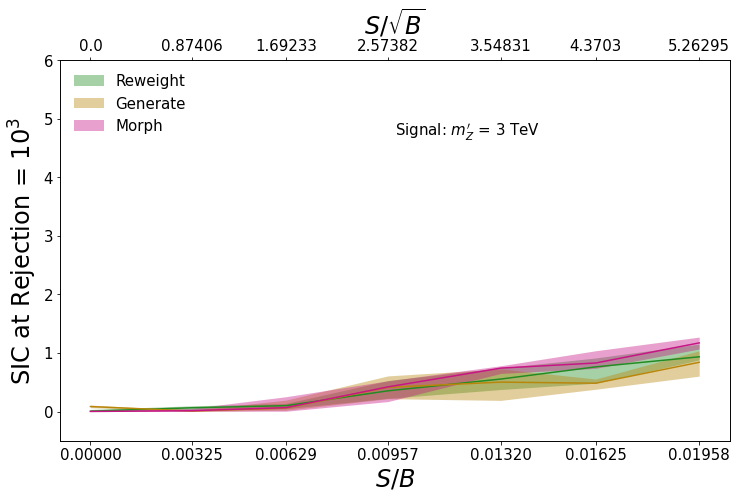

In [38]:
fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:    
   
    ax1.plot(sig_inj_labels, med_sics_at_rej1_dict[k][0], color = colors_dict[k])
    ax1.fill_between(sig_inj_labels, med_sics_at_rej1_dict[k][1],
                        med_sics_at_rej1_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj_labels]).reshape(len(sig_inj_labels),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "upper left")
ax1.set_ylabel("SIC at Rejection = $10^3$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj_labels, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)
#plt.ylim(0,8.8)
plt.ylim(-0.5,6)
plt.text(0.5, 0.8, "Signal: $m_Z'$ = 3 TeV", fontsize=f2, transform=plt.gca().transAxes)

fig.savefig(f"plots/sic_at_rej_1000.pdf")

plt.show()

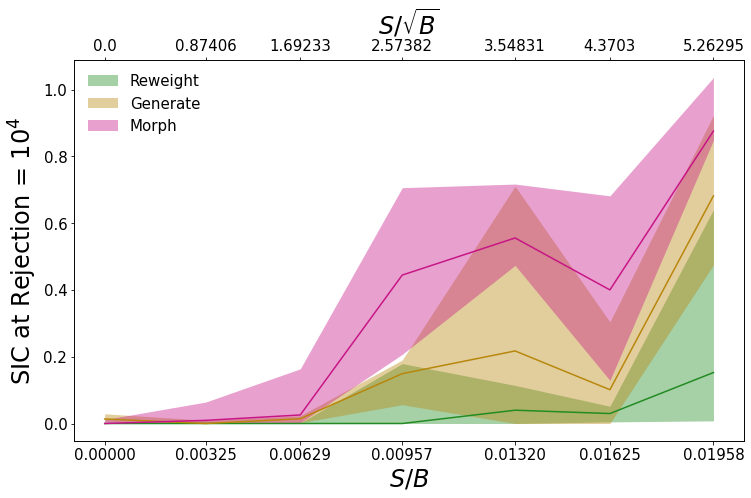

In [39]:
fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:
    
    ax1.plot(sig_inj_labels, med_sics_at_rej2_dict[k][0], color = colors_dict[k])
    ax1.fill_between(sig_inj_labels, med_sics_at_rej2_dict[k][1],
                        med_sics_at_rej2_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj_labels]).reshape(len(sig_inj_labels),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "upper left")
ax1.set_ylabel("SIC at Rejection = $10^4$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj_labels, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

fig.savefig(f"plots/sic_at_rej_10000.pdf")

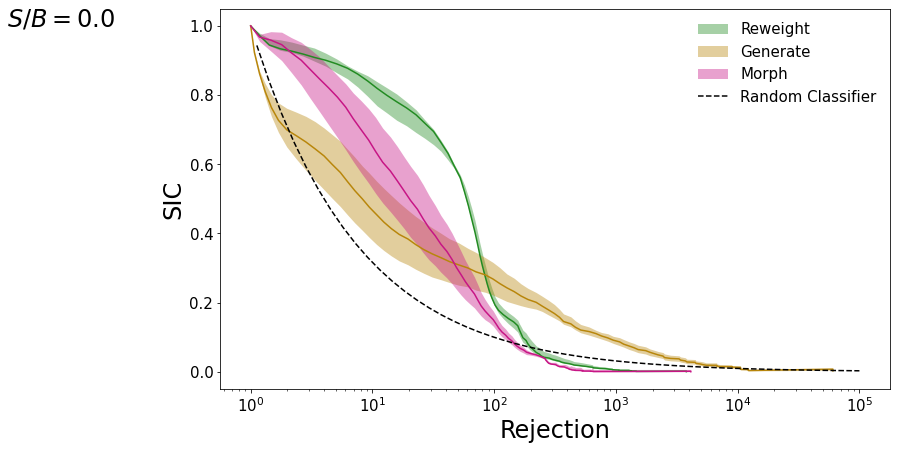

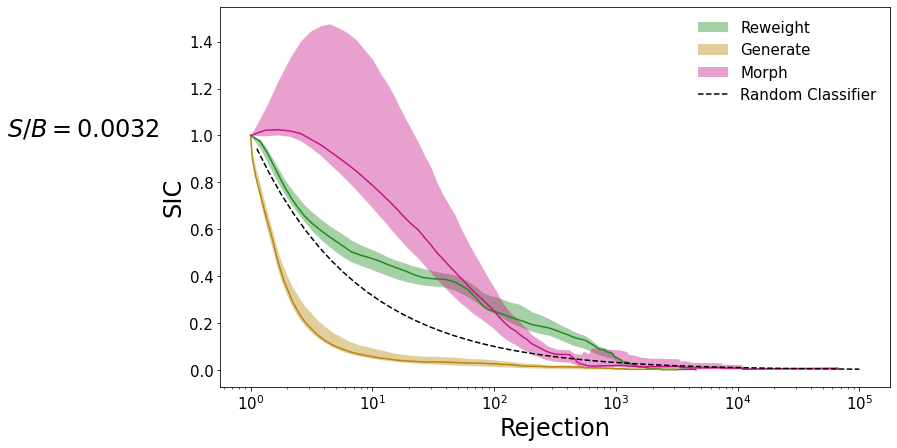

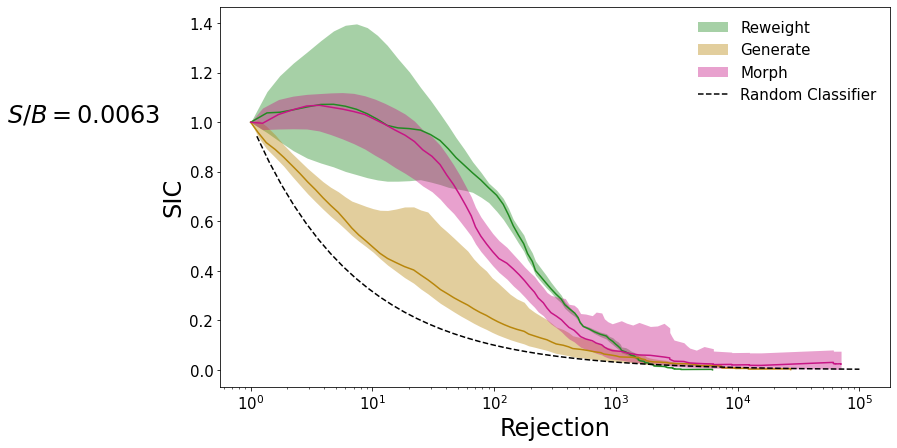

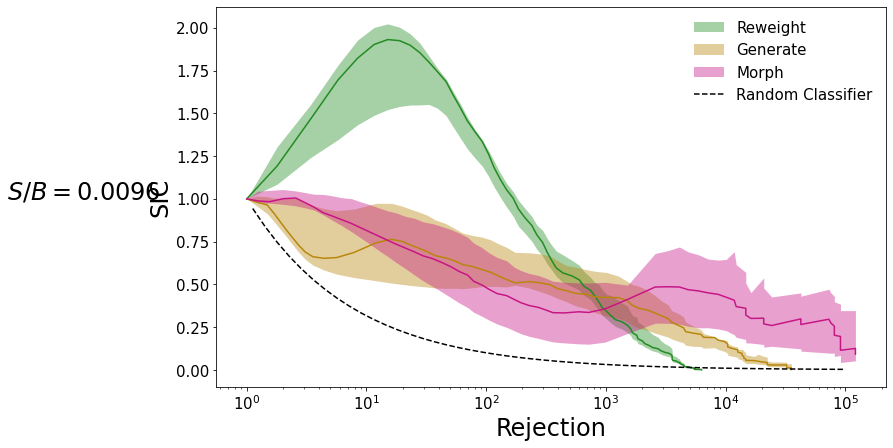

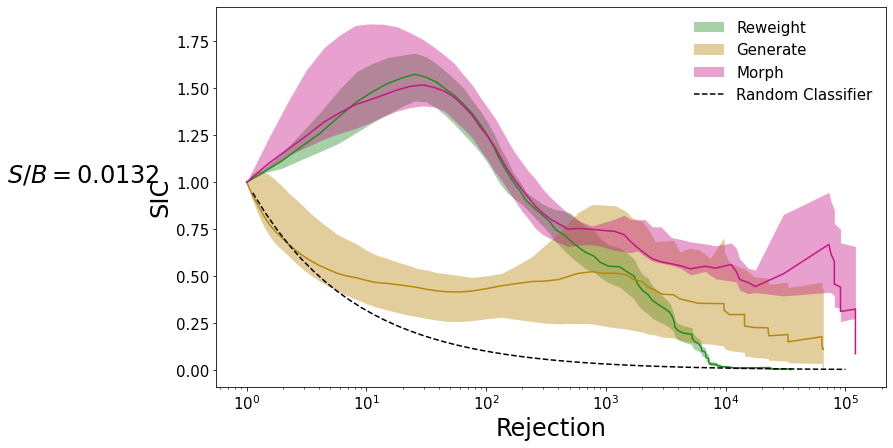

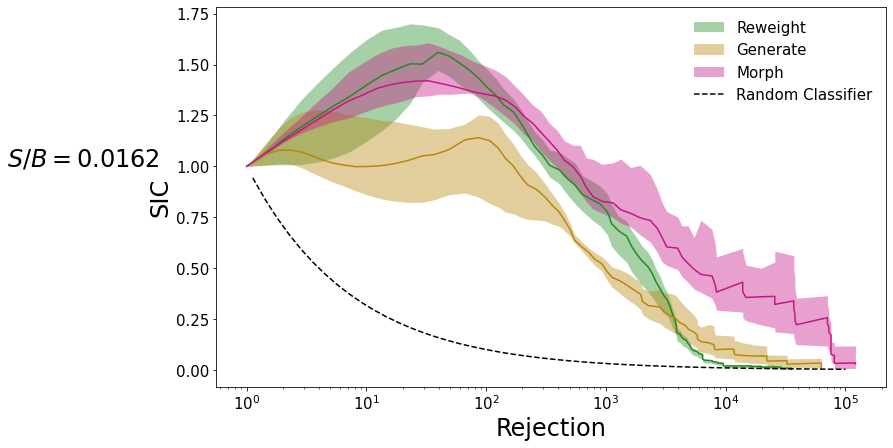

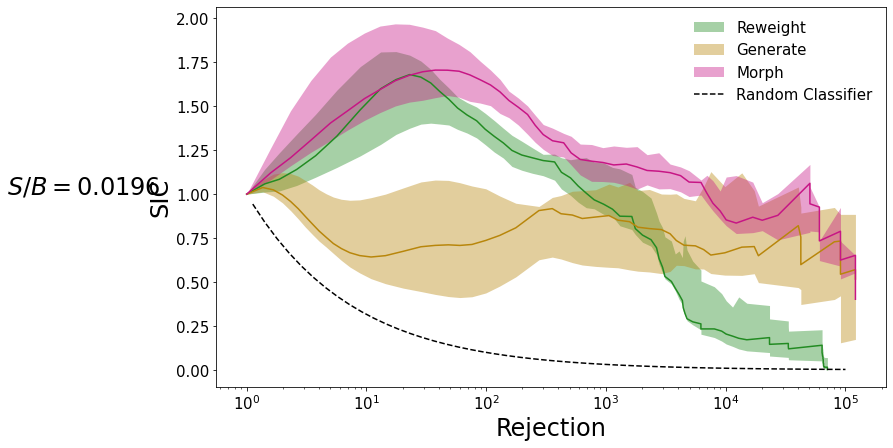

In [91]:
n_to_plot = med_rocs_dict['reweight'].keys()
for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], color = colors_dict[k])

        plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                    med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    # plt.plot(x_axis[60:], x_axis[60:]/np.sqrt(x_axis[60:]), label = "Random", color = "black",)
    # plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black",)
    rejection_values = np.logspace(-5, 5, 100)
    sic_random = 1 / np.sqrt(rejection_values[50:])
    plt.plot(rejection_values[50:], sic_random, linestyle="dashed", color="black", label="Random Classifier")

    
    plt.xscale("log")    
    plt.text(0.01, 1, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False,)
    plt.xlabel("Rejection", fontsize = f1)
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize = f2)
        
    plt.show()

In [49]:
print(med_rocs_dict['reweight'].keys())

dict_keys([0.0, 0.00325, 0.00629, 0.00957, 0.0132, 0.01625, 0.01958])


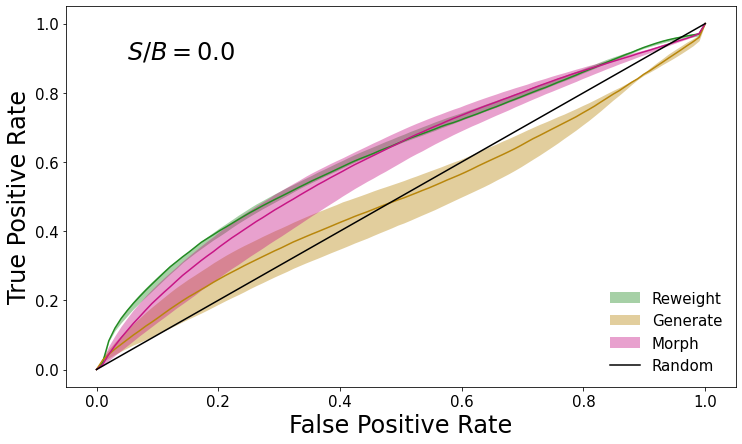

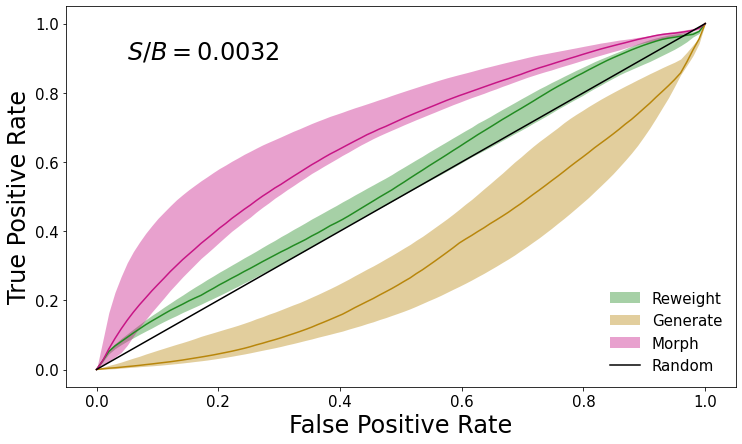

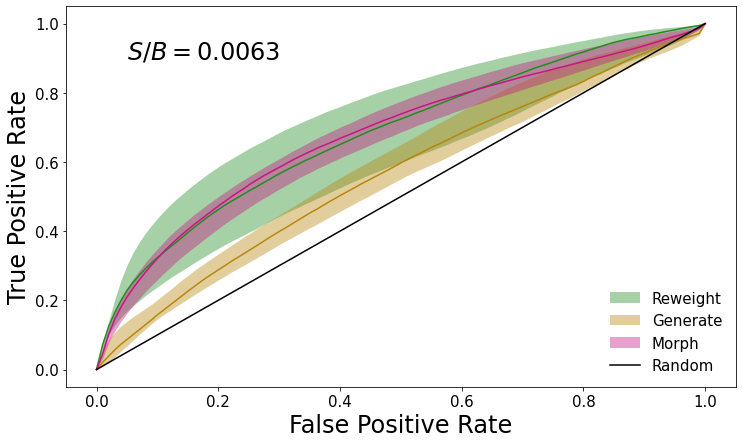

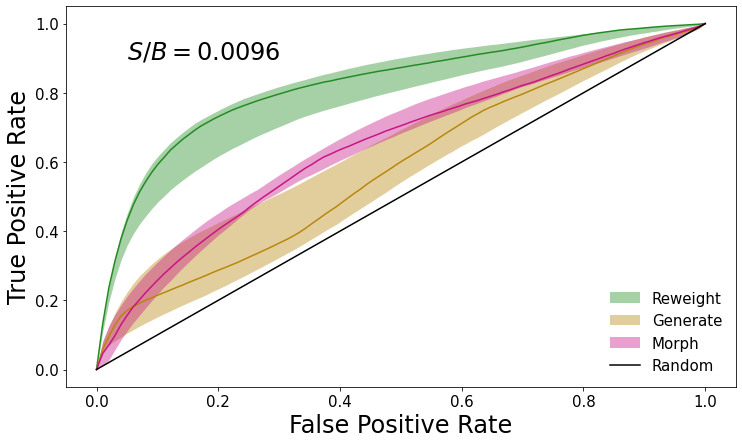

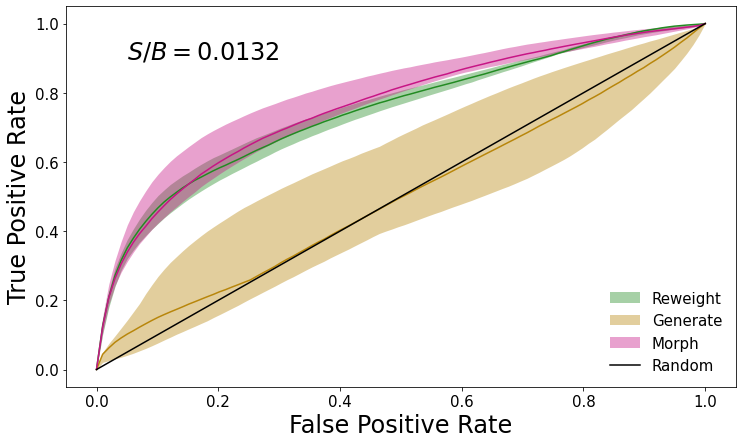

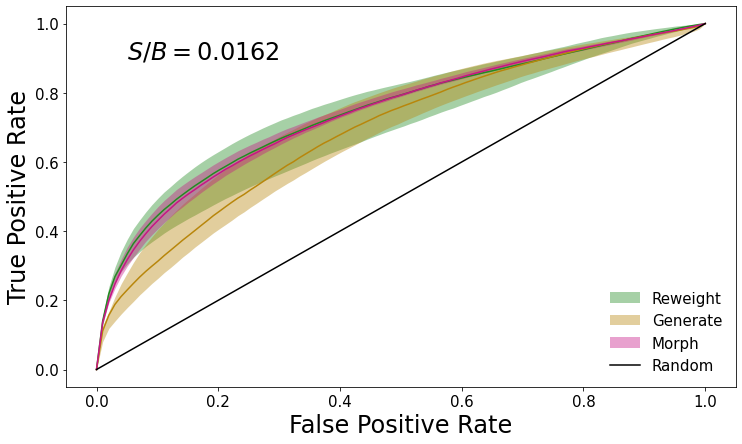

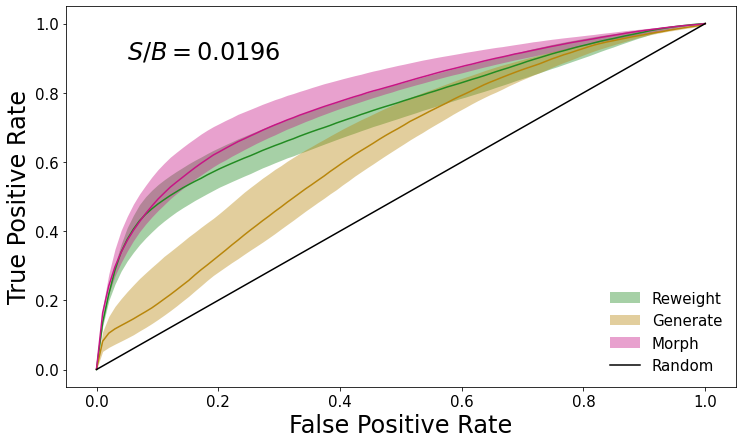

In [50]:
n_to_plot = med_rocs_dict['reweight'].keys()
for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:

        plt.plot(x_axis_roc, med_rocs_dict[k][n][0], color = colors_dict[k])

        plt.fill_between(x_axis_roc, med_rocs_dict[k][n][1],
                    med_rocs_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis_roc, x_axis_roc, label = "Random", color = "black",)

    plt.text(0.05, 0.9, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("False Positive Rate", fontsize = f1)    
    plt.ylabel("True Positive Rate", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    
    plt.show()


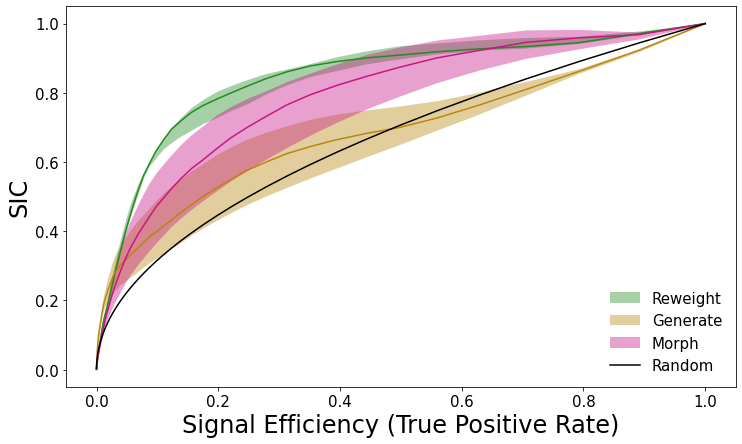

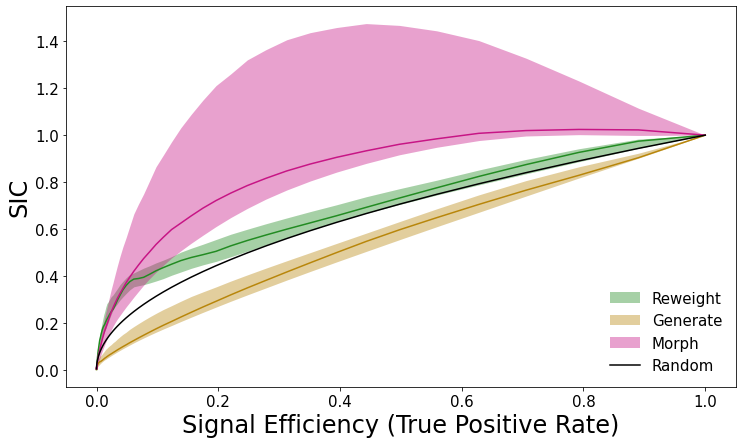

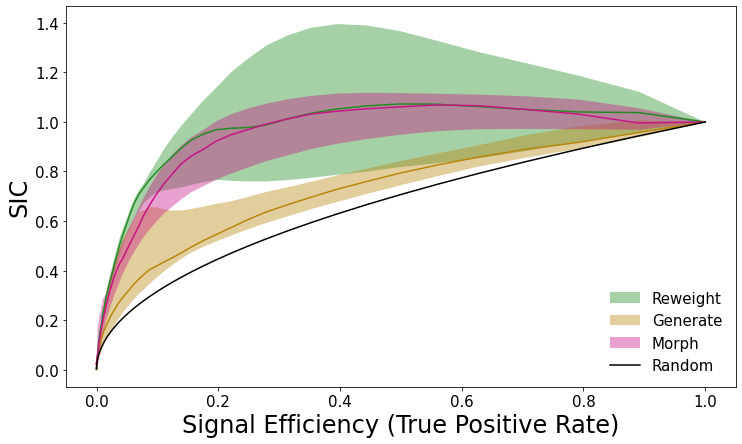

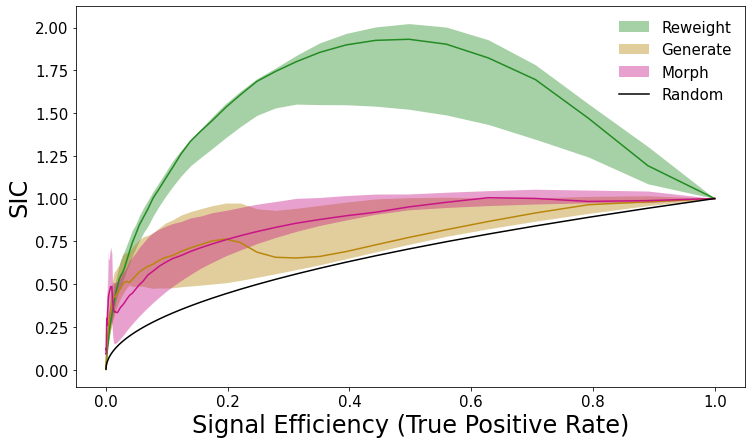

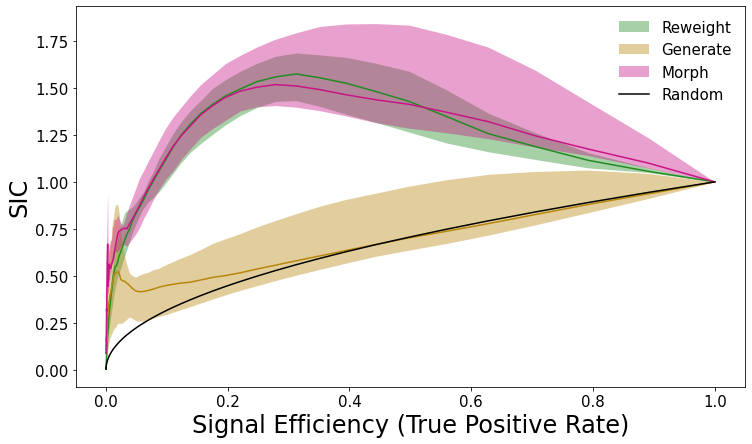

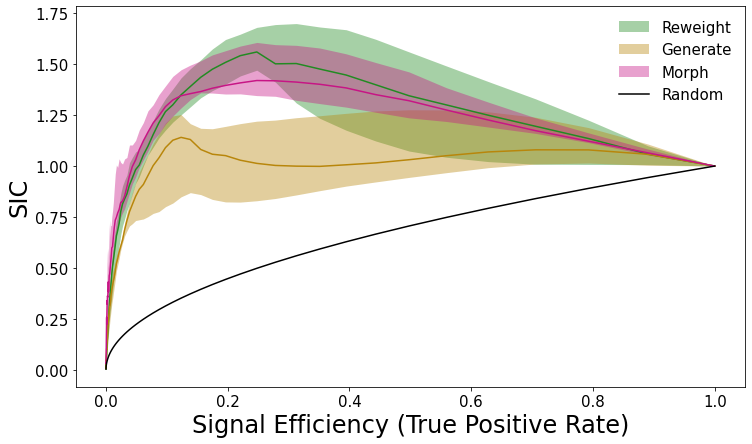

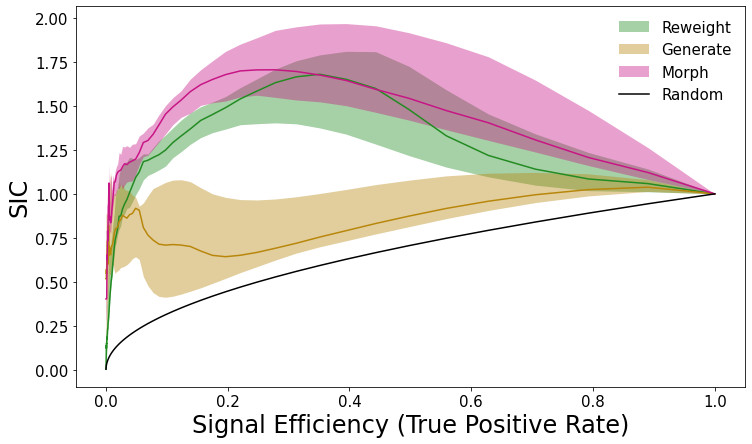

In [51]:
n_to_plot = med_rocs_dict['reweight'].keys()


for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        plt.plot(x_axis, med_sics_dict[k][n][0], color = colors_dict[k])
        plt.fill_between(x_axis, med_sics_dict[k][n][1], med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black",)
        

    # plt.text(0.5, 2, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f1)    
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    # fig.savefig(f"plots/sic_0.pdf")    
    plt.show()

### Significance Improvement

In [54]:
# Load the Data with the signal before
gen_seed = 1
# sig_inj_labels
per = [0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024]
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]

data_significance = {}
sig_sr_list = {}
bkg_sr_list = {}
n_sig_sr = {}
n_bkg_sr = {}
for p in per:
    data_significance[f"{p}"] = np.load(f"{working_dir}/data/seed{gen_seed}/data_{p}.npz")
    sig_sr_list[f"sigs_sr{p}"] = data_significance[f"{p}"]["selected_sigs_sr"]
    bkg_sr_list[f"bkg_sr{p}"] = data_significance[f"{p}"]["bkg_events_SR"]

    n_sig_sr[f"n_sig_sr_{p}"] = sig_sr_list[f"sigs_sr{p}"].shape[0]
    n_bkg_sr[f"n_bkg_sr_{p}"] = bkg_sr_list[f"bkg_sr{p}"].shape[0]

In [73]:
# Compare Before and After
significance_before = {}
significance_after = {}
for i, p in enumerate(per):
    print(f"For Signal Injection S/B = {p}")
    signif_b = n_sig_sr[f"n_sig_sr_{p}"]/np.sqrt(n_bkg_sr[f"n_bkg_sr_{p}"])
    significance_before[f"sig_b_p{p}"] = signif_b
    print("Significance Before =", signif_b)
    print(" == Significance After == ")
    for models in ['reweight', 'generate', 'morph']:
        signif_a = med_max_sics_dict[models][0][i]*signif_b
        significance_after[f"model_{models}_p{p}"] = signif_a
        print(f"For {models}:", signif_a)
        
    print()
    print()

For Signal Injection S/B = 0
Significance Before = 0.0
 == Significance After == 
For reweight: 0.0
For generate: 0.0
For morph: 0.0


For Signal Injection S/B = 0.004
Significance Before = 0.8740590333370666
 == Significance After == 
For reweight: 0.8740590333370666
For generate: 0.8740590333370666
For morph: 0.9008311552688465


For Signal Injection S/B = 0.008
Significance Before = 1.6923270645462354
 == Significance After == 
For reweight: 1.9275632911310094
For generate: 1.6923270645462354
For morph: 1.8235451014469422


For Signal Injection S/B = 0.012
Significance Before = 2.5738248981670218
 == Significance After == 
For reweight: 4.989128131341793
For generate: 2.629020493308513
For morph: 2.7151833902079017


For Signal Injection S/B = 0.016
Significance Before = 3.5483077353343044
 == Significance After == 
For reweight: 5.589948063598281
For generate: 3.8032337942035244
For morph: 5.460888208176276


For Signal Injection S/B = 0.02
Significance Before = 4.370295166685333
 

In [66]:
import pandas as pd

# Data
data = {
    "Signal Injection S/B": [0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024],
    "Significance Before": [0.0, 0.8740590333370666, 1.6923270645462354, 2.5738248981670218, 
                            3.5483077353343044, 4.370295166685333, 5.262951200731699],
    "Reweight After": [0.0, 0.8740590333370666, 1.9275632911310094, 4.989128131341793, 
                       5.589948063598281, 6.857944458446704, 8.915946976430085],
    "Generate After": [0.0, 0.8740590333370666, 1.6923270645462354, 2.629020493308513, 
                       3.8032337942035244, 5.523004139159278, 6.341642502278446],
    "Morph After": [0.0, 0.9008311552688465, 1.8235451014469422, 2.7151833902079017, 
                    5.460888208176276, 6.285963153941718, 9.04697270718561]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


   Signal Injection S/B  Significance Before  Reweight After  Generate After  \
0                 0.000             0.000000        0.000000        0.000000   
1                 0.004             0.874059        0.874059        0.874059   
2                 0.008             1.692327        1.927563        1.692327   
3                 0.012             2.573825        4.989128        2.629020   
4                 0.016             3.548308        5.589948        3.803234   
5                 0.020             4.370295        6.857944        5.523004   
6                 0.024             5.262951        8.915947        6.341643   

   Morph After  
0     0.000000  
1     0.900831  
2     1.823545  
3     2.715183  
4     5.460888  
5     6.285963  
6     9.046973  


In [76]:
significance_after

{'model_reweight_p0': 0.0,
 'model_generate_p0': 0.0,
 'model_morph_p0': 0.0,
 'model_reweight_p0.004': 0.8740590333370666,
 'model_generate_p0.004': 0.8740590333370666,
 'model_morph_p0.004': 0.9008311552688465,
 'model_reweight_p0.008': 1.9275632911310094,
 'model_generate_p0.008': 1.6923270645462354,
 'model_morph_p0.008': 1.8235451014469422,
 'model_reweight_p0.012': 4.989128131341793,
 'model_generate_p0.012': 2.629020493308513,
 'model_morph_p0.012': 2.7151833902079017,
 'model_reweight_p0.016': 5.589948063598281,
 'model_generate_p0.016': 3.8032337942035244,
 'model_morph_p0.016': 5.460888208176276,
 'model_reweight_p0.02': 6.857944458446704,
 'model_generate_p0.02': 5.523004139159278,
 'model_morph_p0.02': 6.285963153941718,
 'model_reweight_p0.024': 8.915946976430085,
 'model_generate_p0.024': 6.341642502278446,
 'model_morph_p0.024': 9.04697270718561}

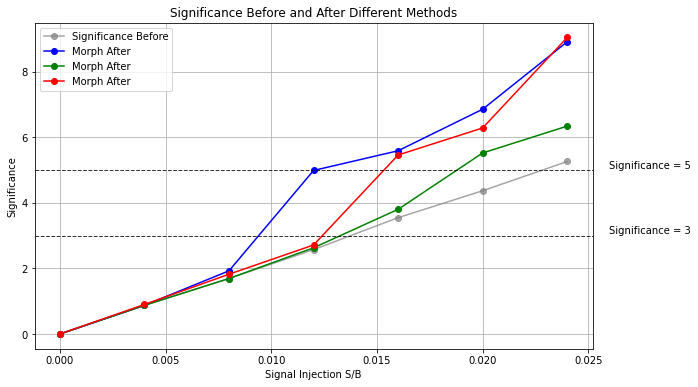

In [79]:
plt.figure(figsize=(10, 6))

# Plot "Significance Before" in grey
# plt.plot(df["Signal Injection S/B"], df["Significance Before"], marker='o', linestyle='-', color='grey', label="Significance Before", alpha=0.7)
plt.plot(per, [significance_before[f"sig_b_p{x}"] for x in per], marker='o', linestyle='-', color='grey', label="Significance Before", alpha=0.7)
# Plot the other significance measures in different colors
colors = ['blue', 'green', 'red']  # Assign colors to other lines
for idx, model in enumerate(['reweight', 'generate', 'morph']):
    plt.plot(per, [significance_after[f"model_{model}_p{x}"] for x in per], marker='o', linestyle='-', label=col, color=colors[idx])
# for idx, col in enumerate(df.columns[2:]):  # Exclude first two columns
    # plt.plot(df["Signal Injection S/B"], df[col], marker='o', linestyle='-', label=col, color=colors[idx])

# Add horizontal lines at significance = 3 and 5
plt.axhline(y=3, color='black', linestyle='--', linewidth=1, alpha=0.8)
plt.axhline(y=5, color='black', linestyle='--', linewidth=1, alpha=0.8)

# Add floating text annotations for significance lines
plt.text(df["Signal Injection S/B"].iloc[-1] + 0.002, 3, "Significance = 3", verticalalignment='bottom', fontsize=10, color='black')
plt.text(df["Signal Injection S/B"].iloc[-1] + 0.002, 5, "Significance = 5", verticalalignment='bottom', fontsize=10, color='black')

# Labels and Title

# Labels and Title
plt.xlabel("Signal Injection S/B")
plt.ylabel("Significance")
plt.title("Significance Before and After Different Methods")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()
